In [5]:

import os
from functools import partial
import numpy as np
from warnings import warn

import numpy as np
import nibabel as nib
import pandas as pd
from pathlib import Path
from nilearn.interfaces.bids import save_glm_to_bids
from nilearn.glm.first_level import make_first_level_design_matrix

In [1]:
from nilearn.glm.first_level import first_level_from_bids
from bids import BIDSLayout
from nipype.interfaces.base import SimpleInterface, TraitedSpec, BaseInterfaceInputSpec, File, traits, Directory
import re
bids_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/"
task_label = "nbk"
space_label = "fsLR"
derivatives_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep"
dense = '91k'
session = '01'
participant_label = 'CMHWM027'
# img_filters= [
#     # ('run','1'),
#     ('ses','01') # Need to add a condition for ses-01 and ses-02 default all
# ] 
# img_filters = []

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# emacs: -*- mode: python; py-indent-offset: 4; indent-tabs-mode: nil -*-
# vi: set ft=python sts=4 ts=4 sw=4 et:
"""
Utilities to handle BIDS inputs
"""

import logging
from warnings import warn

from bids import BIDSLayout

# Setup logging configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


class GLMBIDSInput:
    def __init__(self, bids_dir, derivatives_dir, task_label, participant_label, session):
        self.bids_dir = bids_dir
        self.derivatives_dir = derivatives_dir
        self.task_label = task_label
        self.participant_label = participant_label
        self.session = session

    def __repr__(self):
        # Detailed string for debugging or logging
        params = "\n".join(f"  {key}: {value}" for key, value in self.__dict__.items())
        return f"GLMBIDSInput(\n{params}\n"

class ParticipantValidator(GLMBIDSInput):
    """
    Validates whether fMRI BOLD NIfTI files and corresponding task event TSV files exist
    for a given participant, session, and task within a BIDS dataset.
    """

    def __init__(self, bids_dir, derivatives_dir, task_label, participant_label, session):
        """
        Initializes the validator.

        Args:
            bids_dir (str): Path to the BIDS dataset.
            task_label (str): Task name to validate.
            participant_label (str, optional): Subject ID (e.g., "CMHWM01"). Defaults to None.
            session (str, optional): Session label (e.g., "01"). Defaults to None.
        """
        super().__init__(bids_dir,
                        derivatives_dir, 
                        task_label, 
                        participant_label,
                        session
                        )
        self.layout = BIDSLayout(bids_dir, derivatives=derivatives_dir, validate=False)
        self.valid_participant = self._get_valid_participant()
        
    def __repr__(self):
        # Detailed string for debugging or logging
        params = "\n".join(f"  {key}: {value}" for key, value in self.__dict__.items())
        return f"GLMBIDSInput(\n{params}\n"
    
    def _get_func_img(self):
        sub_imgs = self.layout.get(
            extension="nii.gz",
            suffix="bold",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            space='fsLR',
            den='91k',
        )
        return sub_imgs

    def _get_events_files(self):
        sub_events_files = self.layout.get(
            extension="tsv",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            suffix="events",
            scope="raw",
        )
        return sub_events_files

    def _find_matching_runs(self, verbose):
        valid_sessions = []
        missing_img_runs = set()
        missing_events_runs = set()
        
        session = f"ses-{self.session}"
        sub_imgs = self._get_func_img()
        sub_events = self._get_events_files()
        if not sub_imgs:
            raise ValueError(
                f"No functional images found for {session}. Skipping {self.participant_label}"
            )
        if not sub_events:
            raise ValueError(
                f"No task events found for {session}. Skipping {self.participant_label}"
            )
        
        # Extract available run numbers
        run_pattern = re.compile(r"run-(\d+)")
        img_runs = set()

        for img in sub_imgs:
            match = run_pattern.search(img.filename)
            if match:
                img_runs.add(int(match.group(1)))

        events_runs = set()
        for events in sub_events:
            match = run_pattern.search(events.filename)
            if match:
                events_runs.add(int(match.group(1)))

        # Find runs that are both in images and events
        matching_runs = img_runs.intersection(events_runs)
        missing_img_runs = events_runs - img_runs
        missing_events_runs = img_runs - events_runs

        if matching_runs:
            valid_sessions = [(session, f"run-{run}") for run in sorted(matching_runs)]
        
        if missing_img_runs and verbose:
            print(f"{self.participant_label} has missing functional BOLD file for the following runs in {session}: run-{', '.join(map(str, missing_img_runs))}.")
    
        if missing_events_runs and verbose:
            print(f"{self.participant_label} has missing task events files for the following runs in {session}: run-{', '.join(map(str, missing_events_runs))}.")

        return valid_sessions
    
    def _get_valid_participant(self, verbose=True):

        """
        Retrieves valid session-run pairs for a given participant based on the presence of 
        functional images and task event files.

        Args:
            verbose (bool, optional): If True (default), prints information about missing runs 
                                    and valid sessions. If False, suppresses output.

        Returns:
            dict: A dictionary containing:
                - key (str): The participant label (e.g., "CMHWM027")
                - value (list of tuples): Each tuple contains:
                    - session (str): The session identifier (e.g., "ses-01")
                    - run (str): The run identifier (e.g., "run-1")
        
        Example:
            >>> validator = ParticipantValidator(bids_dir, "task-rest", "CMHWM027", "01")
            >>> valid_participant = validator.get_valid_participant(verbose=False)
            >>> print(valid_participant)
            {"CMHWM027": [("ses-01", "run-1"), ("ses-01", "run-2")]}
    """
        valid_sessions = self._find_matching_runs(verbose)
        valid_participant = {}
        if valid_sessions:
            valid_participant[self.participant_label] = valid_sessions
        return valid_participant
        
# write a BIDS stats model in json format
class ModelConfig:
    """
    Set up the 1st-level GLM

    Inputs:
        filename - Full path to the model config json file. If filename is 
                   not set, it will check the environment variable MODEL_CONFIG.
                   The default configuration file is located in the config directory.
    """

    def __init__(
        self,
        filename=None,
        **kwargs
    ):
        
        if not filename:
            try:
                filename = os.environ["MODEL_CONFIG"]
            except KeyError:
                raise ValueError("No default config found in environment variable")
        self._load_json(filename)

        # Override any values using kwargs if necessary
        for key, value in kwargs.items():
            setattr(self, key, value)

    def _load_json(self, filename):
        """
        Load configuration from a JSON file and update instance attributes
        """
        import json
        if not os.path.isfile(filename):
            raise ValueError(
                f"Configuration file {filename} not found. Try again"
            )
        with open(filename, "r") as f:
            config_data = json.load(f)

        # Update the instance attributes with values from the JSON
        for key, value in config_data.items():
            setattr(self, key, value)
                
    def __repr__(self):
        # Detailed string for debugging or logging
        return f"ModelConfig({', '.join(f'{key}={value!r}' for key, value in self.__dict__.items())})"
    
class GLMModelInput(GLMBIDSInput):
    def __init__(self, bids_dir, derivatives_dir, task_label, valid_participant, model_config, space_label="fsLR" ):
        super().__init__(bids_dir,
                        derivatives_dir, 
                        task_label, 
                        participant_label=None,
                        session=None)
        self.valid_participant = valid_participant
        self.model_config = model_config
        self.space_label = space_label
        
    def process_and_fit_valid_participant_model(self):
        for entry in self._iter_valid_participants():

            participant, session, run = entry["participant"], entry["session"], entry["run"]
            img_filters = []
            img_filters.append(
                tuple(session.split("-"))
            )
            img_filters.append(tuple(run.split("-")))  # Extract run (e.g., '1')
            model_config_dict = vars(self.model_config)

            print(f"Loading models for subject: {participant} | {session} | {run}")
            models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
                self.bids_dir,
                self.task_label,
                space_label=self.space_label,
                sub_labels=[participant],
                derivatives_folder=self.derivatives_dir,
                img_filters=img_filters,
                signal_scaling=False,
                **model_config_dict,
                n_jobs=2,
                )
            print(f"Functional image: {models_run_imgs[0][0]}")
            func_imgs = nib.load(models_run_imgs[0][0])
            print(func_imgs)
            func_data = func_imgs.get_fdata()
            print(f"{func_data.shape}")
            func_data_new = func_data[:,:,:,2:]
            print(func_data_new.shape)
            func_imgs_new = nib.Nifti1Image(func_data_new, affine=func_imgs.affine, header=func_imgs.header)
            print(func_imgs_new)
            dm, _, _ = self._get_design_matrix(models, models_run_imgs, models_events, models_confounds)
        # return dm, events_df, confounds_df
            print(models, models_run_imgs)
            print(f"Models loaded successfully! {participant}  {session} | {run}")
            print(f"Columns of the design matrix: {(dm.columns)}")
            print(f"\n{'='*40}")
            print(f"Fitting Models {participant} | {session} | {run}")
            print(f"Model parameters: {models[0]}")
            first_lvl_glm = models[0].fit(func_imgs_new, design_matrices=dm)

            # Set up output directory    
            outdir = Path(self.derivatives_dir).parent
            glm_dir = outdir / "FirstLevelModel"
            glm_dir.mkdir(exist_ok=True, parents=True)
            print(glm_dir, first_lvl_glm)

            # Join key-value pairs into a single formatted string
            contrasts = {
                            "threebackblock - onebackblock": "threebackblock - onebackblock",
                            "onebackblock": "onebackblock ",
                            "threebackblock": "threebackblock"
                        }

            contrast_types = {
                            "threebackblock - onebackblock": "t",
                            "onebackblock": "t",
                            "threebackblock": "t"
                        }
            save_glm_to_bids(
                first_lvl_glm,
                contrasts=contrasts,
                contrast_types=contrast_types,
                out_dir=glm_dir
                / f"sub-{first_lvl_glm.subject_label}",
                prefix=f"{first_lvl_glm.subject_label}_{session}_task-{self.task_label}_{run}",
            )

    
    def _iter_valid_participants(self):
        """ Generator that yields (participant, session, run) tuples. """
        for participant, sessions_runs in self.valid_participant.items():
            for session, run in sessions_runs:
                yield {"participant": participant, "session": session, "run": run}

    def _get_design_matrix(self, model, model_run_imgs, model_events, model_confounds):
        events_df = model_events[0][0]
        mask_hit = (events_df["correct_response"] == 1) & (
                events_df["participant_response"] == 1
            )
        mask_miss = (events_df["correct_response"] == 1) & (
                events_df["participant_response"] == 0
            )
        mask_false = (events_df["correct_response"] == 0) & (
                events_df["participant_response"] == 1
            )

        events_df.loc[mask_hit, "trial_type"] = (
                events_df["trial_type"].astype(str) + "_hit"
            )
        events_df.loc[mask_false, "trial_type"] = (
                events_df["trial_type"].astype(str) + "_false"
            )
        events_df["onset"] = events_df["onset"] + 8 - 4

        events_df_tmp = events_df[["onset", "duration", "trial_type"]]
        # events_df_tmp = events_df.drop(
        #     columns=["correct_response", "participant_response", "response_time", "block"]
        # )
        # Filter rows where "trial_type" contains "onebackblock" or "threebackblock"
        events_df_final = events_df_tmp[
            events_df["trial_type"].str.contains("onebackblock|threebackblock|oneback_hit|oneback_false|threeback_hit|threeback_false", regex=True)
        ]
        # Confound regressors
        # confounds_df = model_confounds[0][0][
        #     ["global_signal", "csf", "white_matter", "rot_x", "rot_y", "rot_z"]
        # ]
        confound_vars = [col for col in model_confounds[0][0].columns if col.startswith(("white_matter", "csf", "trans", "rot"))]
        confounds_df = model_confounds[0][0][confound_vars]
        confounds_df = confounds_df[2:]
        # for col in confounds_df.columns:
        #     confounds_df.loc[:, col] = confounds_df[col].sub(confounds_df[col].mean())
        func_imgs = nib.load(model_run_imgs[0][0])
        n_scans = func_imgs.shape[-1] - 2
        frame_times = np.arange(n_scans) * model[0].t_r
        print(n_scans,frame_times)
        dm = make_first_level_design_matrix(
            frame_times,
            events_df_final,
            drift_model=model[0].drift_model,
            add_regs=confounds_df,
            add_reg_names=list(confounds_df.columns),
            hrf_model=model[0].hrf_model,
        )
        return dm, events_df_final, confounds_df





In [3]:
inputs = GLMBIDSInput(bids_dir, derivatives_dir, task_label, participant_label, session)
inputs

GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: CMHWM027
  session: 01

In [6]:
os.environ['MODEL_CONFIG'] = '/projects/ttan/SCanD_project/code/glm/config/default_model_config.json'
model_config = ModelConfig()
model_config

ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False)

In [ ]:
bids_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/"
task_label = "nbk"
space_label = "fsLR"
derivatives_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep"
dense = '91k'
session = '01'
participant_label = 'CMHWM027'


In [7]:
participant_labels = ["CMHWM027"]
sessions = ["01", "02"]

CMHWM027 has missing task events files for the following runs in ses-01: run-1.
Loading models for subject: CMHWM027 | ses-01 | run-2
Functional image: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-2_space-fsLR_den-91k_bold.nii.gz

<class 'nibabel.nifti1.Nifti1Image'>
data shape (30428, 3, 1, 420)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [    4 30428     3     1   420     1     1     1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       

/tmp/ipykernel_476278/4023936524.py:235: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM026/ses-01/func/sub-CMHWM026_ses-01_task-nbk_run-2_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(


(30428, 3, 1, 420)
(30428, 3, 1, 418)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (30428, 3, 1, 418)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [    4 30428     3     1   418     1     1     1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Connectome Workben

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/design_matrix.py:416: UserWarning: The following conditions contain events with null duration:
- 'oneback_hit'
- 'threeback_false'
- 'threeback_hit'

  matrix, names = _convolve_regressors(


/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/FirstLevelModel FirstLevelModel(fir_delays=[0], hrf_model='spm + derivative + dispersion',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x71bd49434490>,
                memory=Memory(location=None), minimize_memory=False, n_jobs=2,
                signal_scaling=False, subject_label='CMHWM027', t_r=2)


/tmp/ipykernel_476278/4023936524.py:283: UserWarning: Contrast name "threebackblock - onebackblock" changed to "threebackblockMinusOnebackblock"
  save_glm_to_bids(
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smal

Loading models for subject: CMHWM027 | ses-02 | run-1
Functional image: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.nii.gz


/tmp/ipykernel_476278/4023936524.py:235: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM027/ses-02/func/sub-CMHWM027_ses-02_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(



<class 'nibabel.nifti1.Nifti1Image'>
data shape (32767, 3, 1, 420)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [    4 32767     3     1   420     1     1     1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Connectome Workbench, version 1.4.1')
aux_file        : 

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/design_matrix.py:416: UserWarning: The following conditions contain events with null duration:
- 'oneback_hit'
- 'threeback_false'
- 'threeback_hit'

  matrix, names = _convolve_regressors(


/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/FirstLevelModel FirstLevelModel(fir_delays=[0], hrf_model='spm + derivative + dispersion',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x71bd4a6311e0>,
                memory=Memory(location=None), minimize_memory=False, n_jobs=2,
                signal_scaling=False, subject_label='CMHWM027', t_r=2)


/tmp/ipykernel_476278/4023936524.py:283: UserWarning: Contrast name "threebackblock - onebackblock" changed to "threebackblockMinusOnebackblock"
  save_glm_to_bids(
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smal

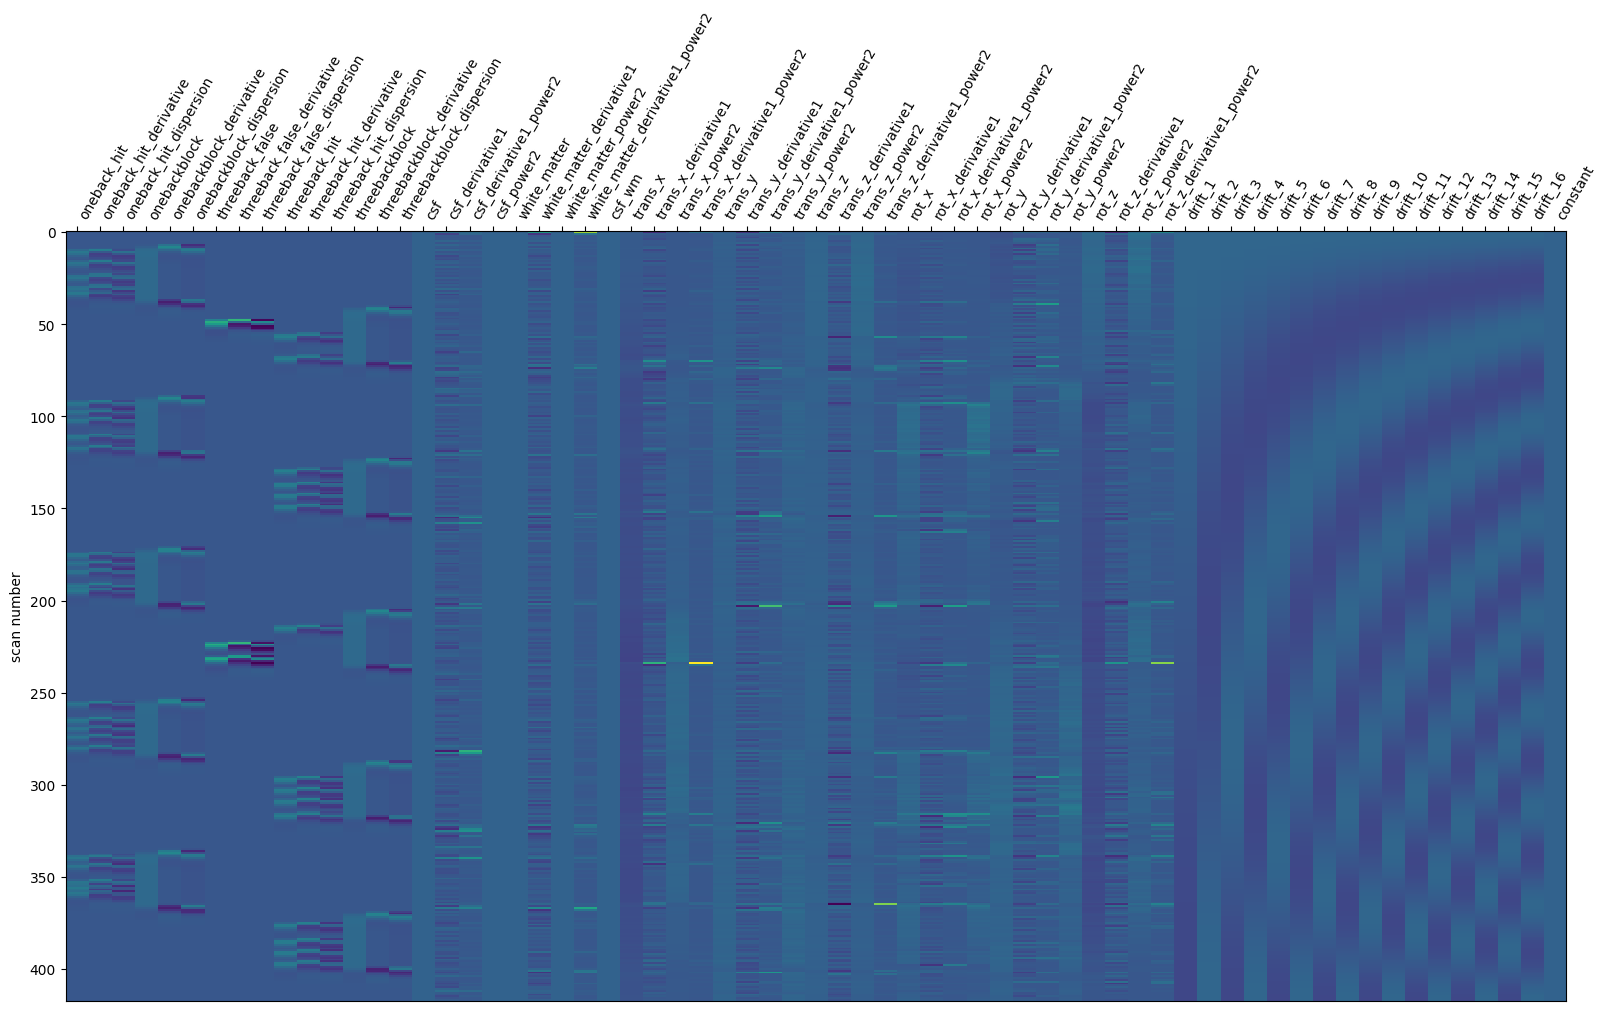

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


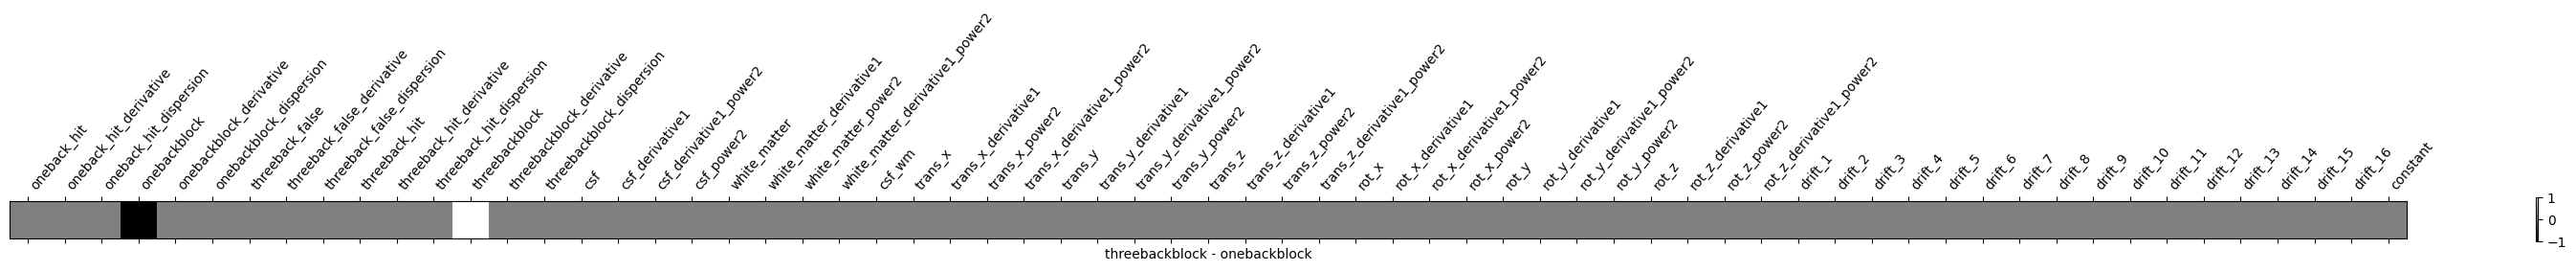

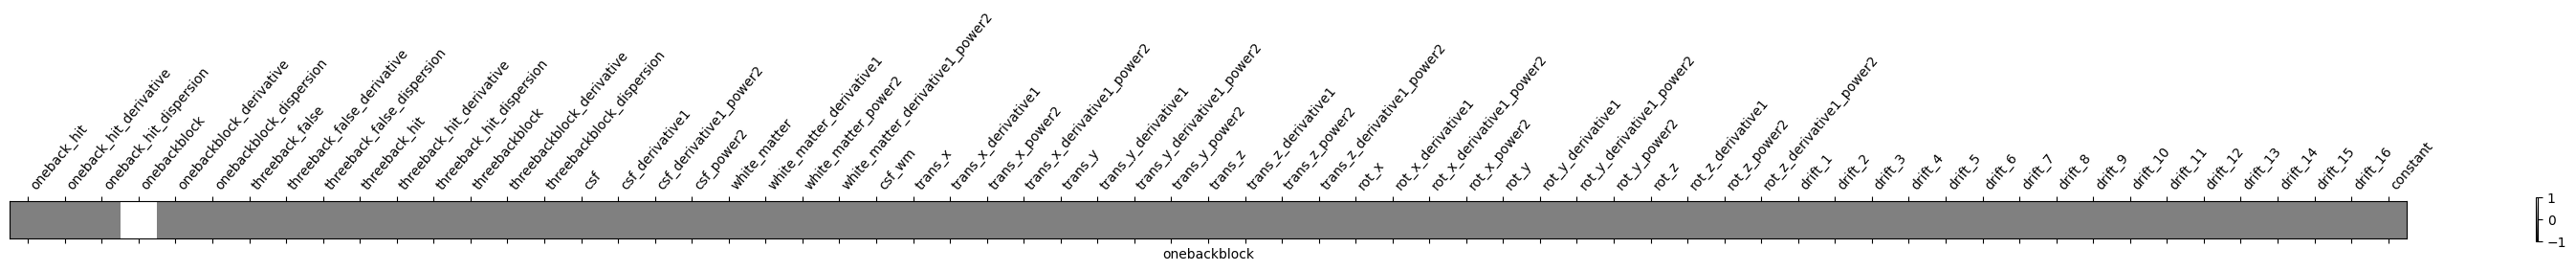

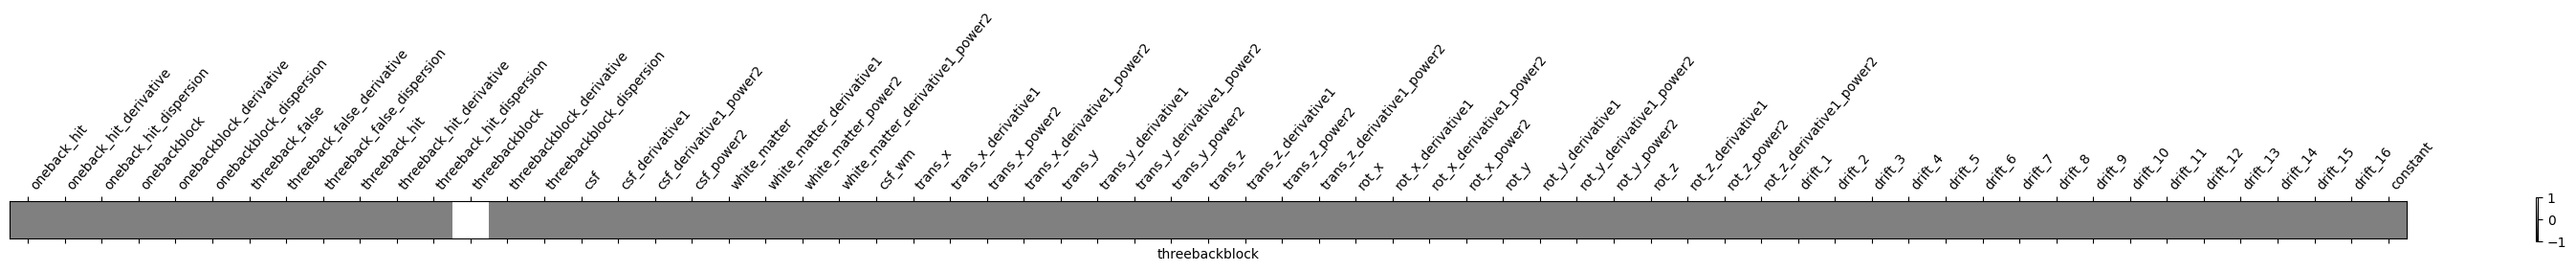

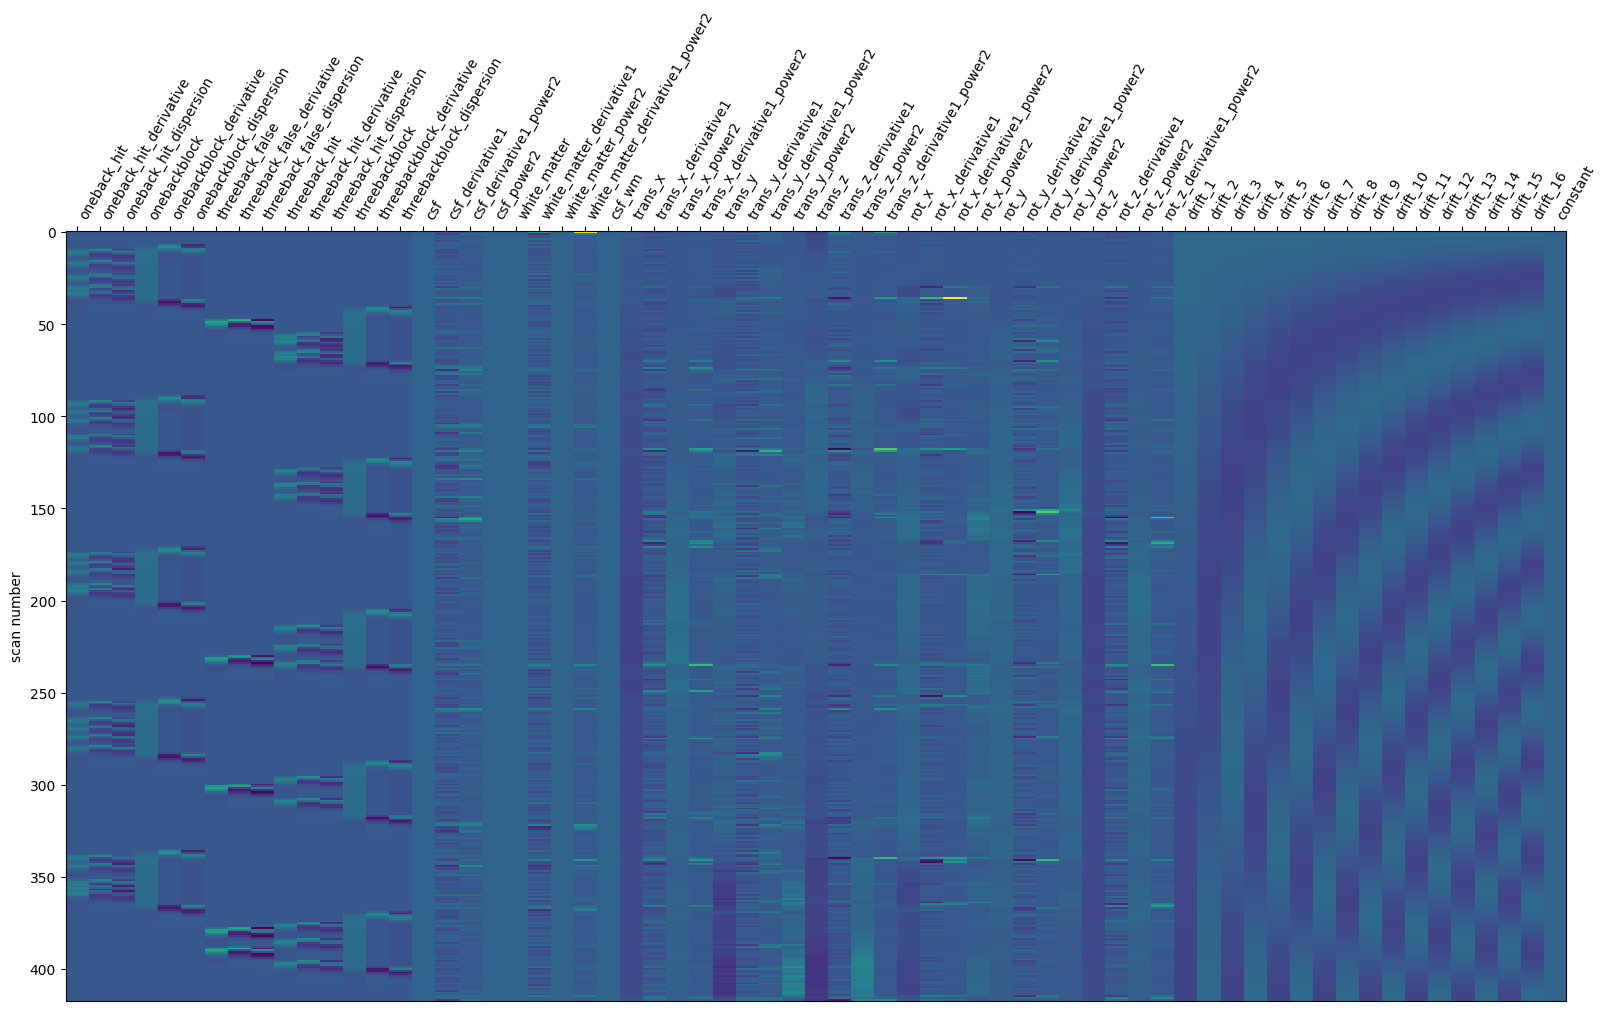

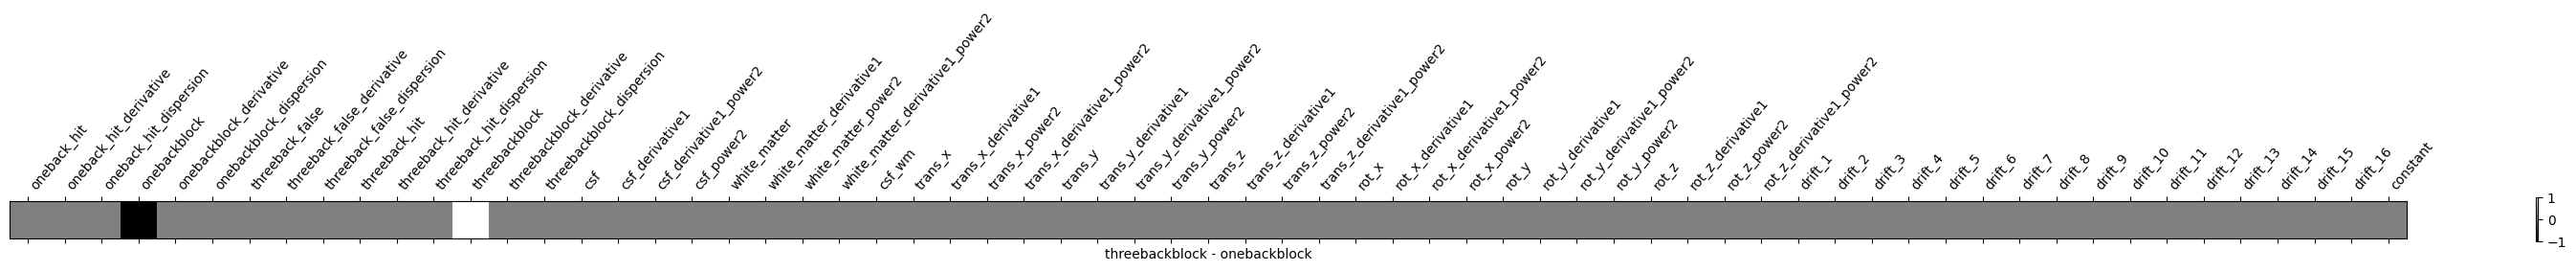

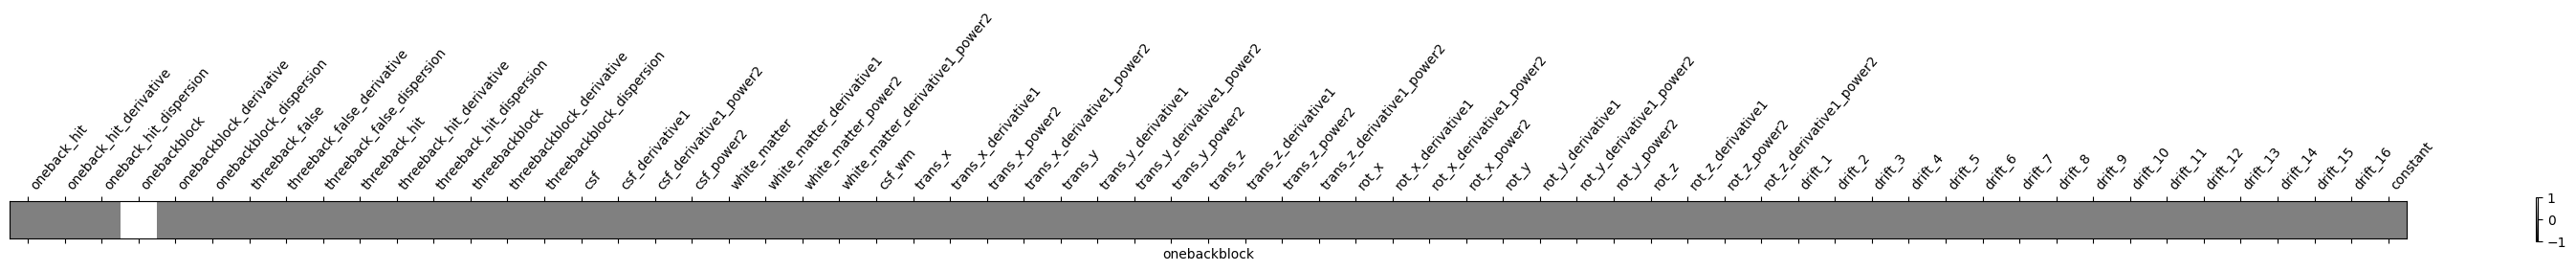

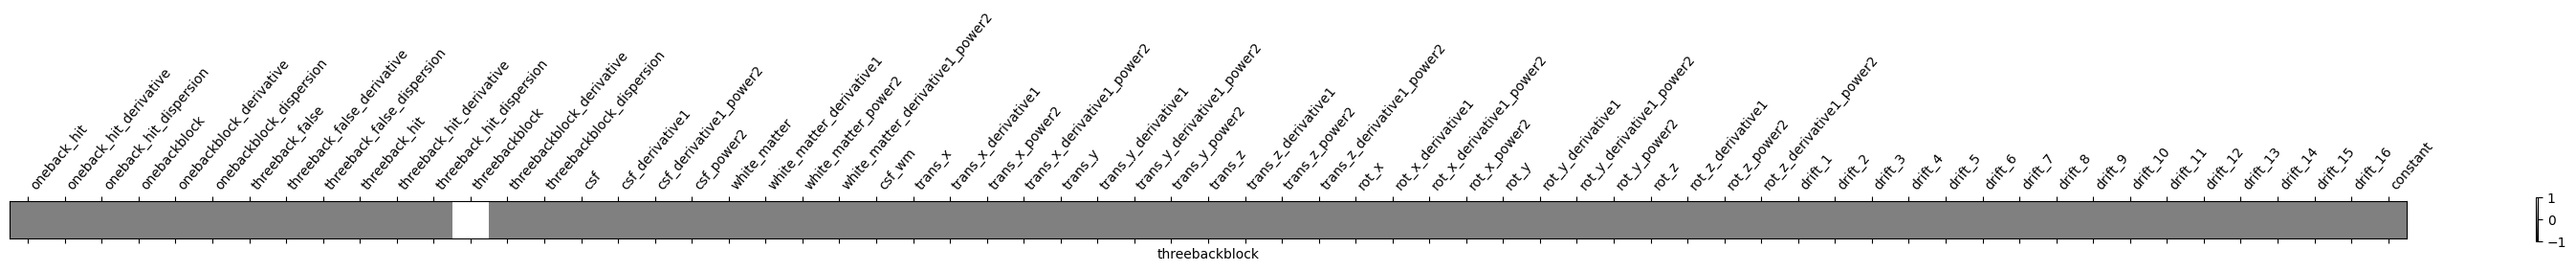

In [8]:
for participant_label in participant_labels:
    for session in sessions:
        import re
        validator = ParticipantValidator(bids_dir, derivatives_dir, task_label, participant_label, session)
        load_model = GLMModelInput(bids_dir, derivatives_dir, task_label, validator.valid_participant, model_config, space_label)
        load_model.process_and_fit_valid_participant_model()


In [112]:
import re
validator = ParticipantValidator(bids_dir, derivatives_dir, task_label, participant_label, session)
validator

CMHWM027 has missing task events files for the following runs in ses-01: run-1.


GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: CMHWM027
  session: 01
  layout: BIDS Layout: ..._pipelines_scc/data/local/bids | Subjects: 5 | Sessions: 9 | Runs: 7
  valid_participant: {'CMHWM027': [('ses-01', 'run-2')]}

In [113]:
load_model = GLMModelInput(bids_dir, derivatives_dir, task_label, validator.valid_participant, model_config, space_label)

In [114]:
load_model

GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: None
  session: None
  valid_participant: {'CMHWM027': [('ses-01', 'run-2')]}
  model_config: ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False)
  space_label: fsLR

Loading models for subject: CMHWM027 | ses-01 | run-2
Functional image: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-2_space-fsLR_den-91k_bold.nii.gz

<class 'nibabel.nifti1.Nifti1Image'>
data shape (30428, 3, 1, 420)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [    4 30428     3     1   420     1     1     1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_u

/tmp/ipykernel_2966554/1426986320.py:235: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM026/ses-01/func/sub-CMHWM026_ses-01_task-nbk_run-2_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(


(30428, 3, 1, 420)
(30428, 3, 1, 418)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (30428, 3, 1, 418)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [    4 30428     3     1   418     1     1     1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Connectome Workben

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/first_level/design_matrix.py:416: UserWarning: The following conditions contain events with null duration:
- 'oneback_hit'
- 'threeback_false'
- 'threeback_hit'

  matrix, names = _convolve_regressors(


/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/FirstLevelModel FirstLevelModel(fir_delays=[0], hrf_model='spm + derivative + dispersion',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7e1c19b9f070>,
                memory=Memory(location=None), minimize_memory=False, n_jobs=2,
                signal_scaling=False, subject_label='CMHWM027', t_r=2)


/tmp/ipykernel_2966554/1426986320.py:283: UserWarning: Contrast name "threebackblock - onebackblock" changed to "threebackblockMinusOnebackblock"
  save_glm_to_bids(
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  contrast_plot.figure.savefig(constrast_fig_file)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/interfaces/bids/glm.py:352: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations sma

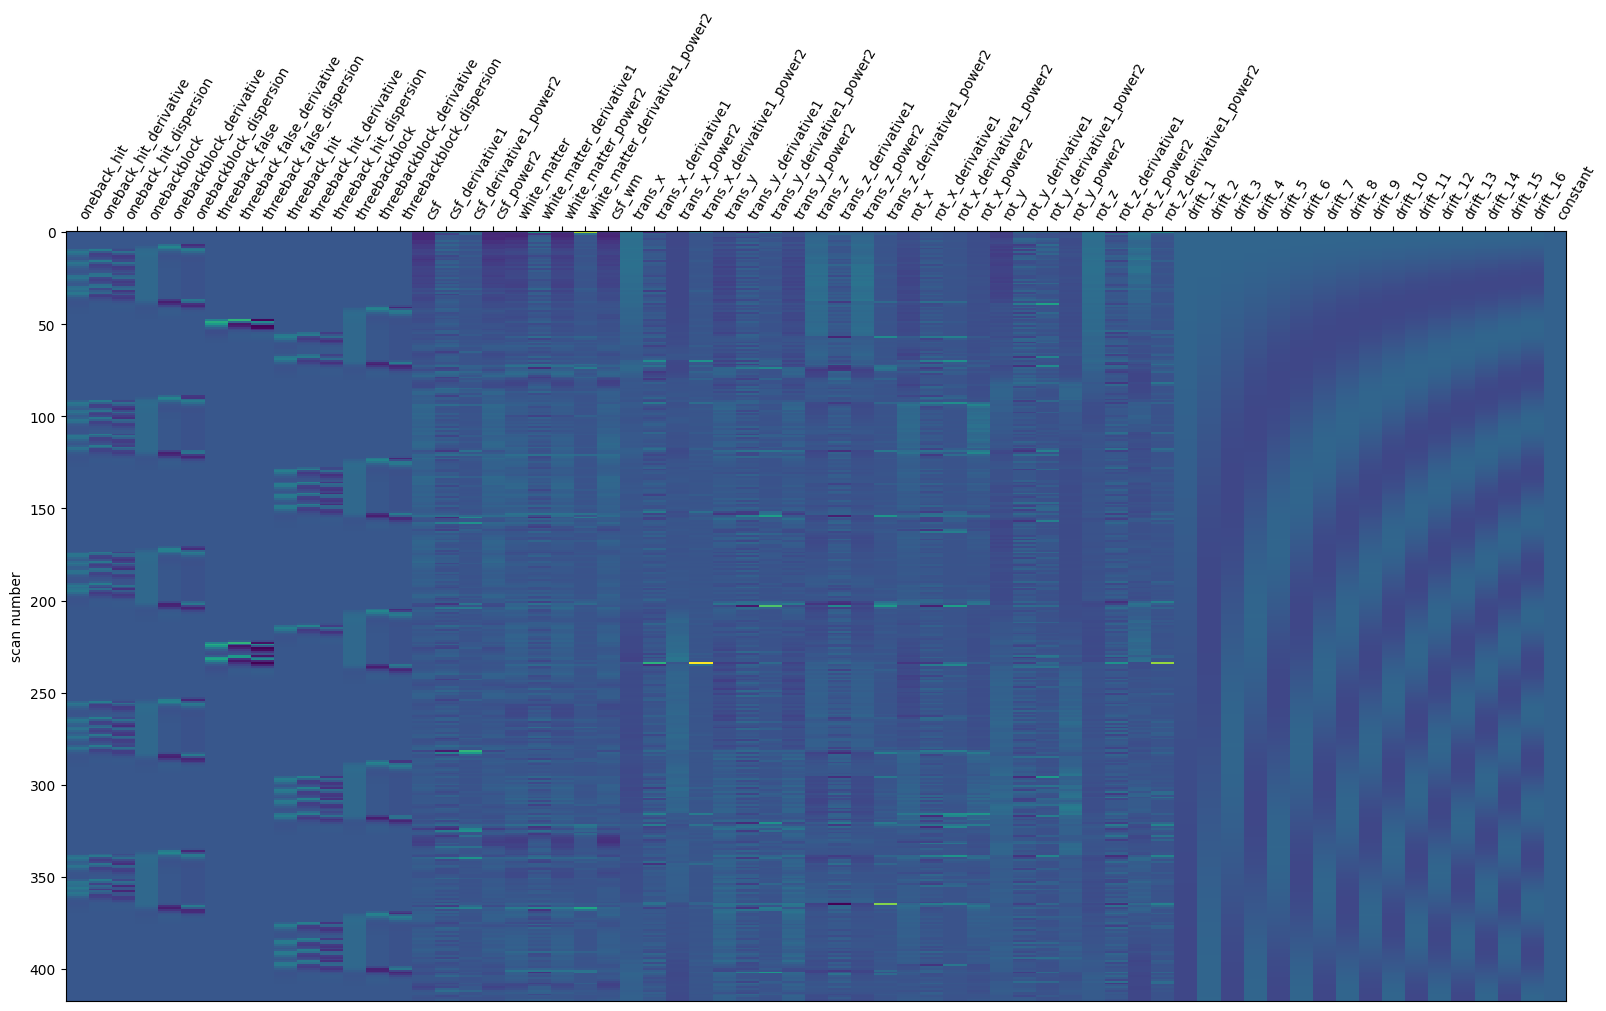

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


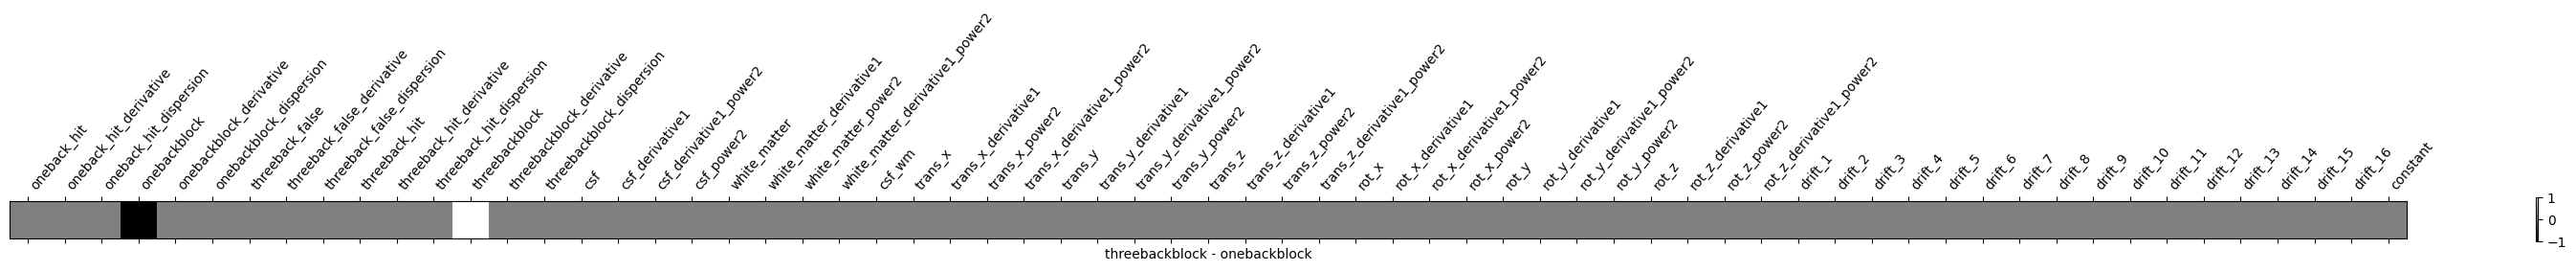

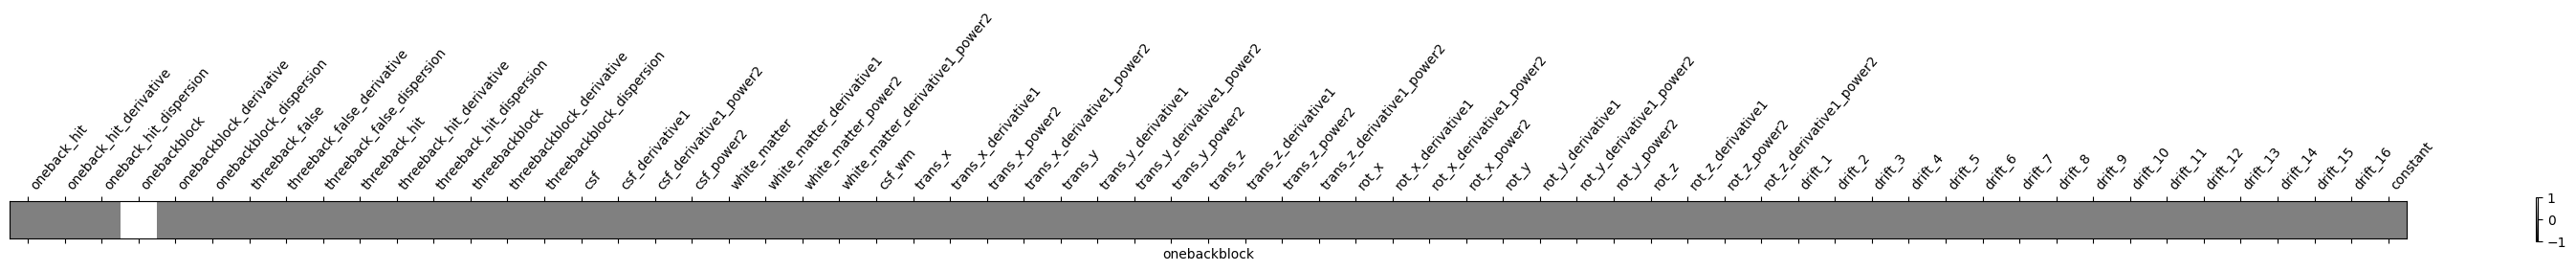

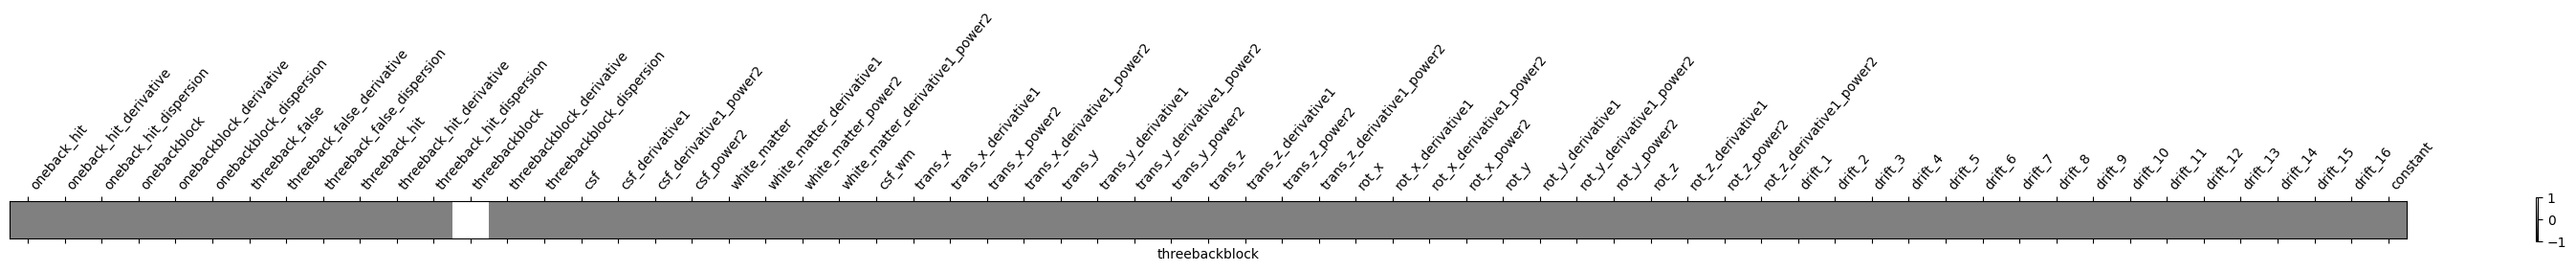

In [115]:
load_model.process_and_fit_valid_participant_model()

In [6]:
class ParticipantValidator(GLMBIDSInput):
    """
    Validates whether fMRI BOLD NIfTI files and corresponding task event TSV files exist
    for a given participant, session, and task within a BIDS dataset.
    """

    def __init__(self, bids_dir, derivatives_dir, task_label, participant_label, session):
        """
        Initializes the validator.

        Args:
            bids_dir (str): Path to the BIDS dataset.
            task_label (str): Task name to validate.
            participant_label (str, optional): Subject ID (e.g., "CMHWM01"). Defaults to None.
            session (str, optional): Session label (e.g., "01"). Defaults to None.
        """
        super().__init__(bids_dir,
                        derivatives_dir, 
                        task_label, 
                        participant_label,
                        session
                        )
        self.layout = BIDSLayout(bids_dir, derivatives=derivatives_dir, validate=False)
        self.valid_participant = self._get_valid_participant()
        
    def __repr__(self):
        # Detailed string for debugging or logging
        params = "\n".join(f"  {key}: {value}" for key, value in self.__dict__.items())
        return f"GLMBIDSInput(\n{params}\n"
    
    def _get_func_img(self):
        sub_imgs = self.layout.get(
            extension="nii.gz",
            suffix="bold",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            space='fsLR',
            den='91k',
        )
        return sub_imgs

    def _get_events_files(self):
        sub_events_files = self.layout.get(
            extension="tsv",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            suffix="events",
            scope="raw",
        )
        return sub_events_files

    def _find_matching_runs(self, verbose):
        valid_sessions = []
        missing_img_runs = set()
        missing_events_runs = set()
        
        session = f"ses-{self.session}"
        sub_imgs = self._get_func_img()
        sub_events = self._get_events_files()
        if not sub_imgs:
            raise ValueError(
                f"No functional images found for {session}. Skipping {self.participant_label}"
            )
        if not sub_events:
            raise ValueError(
                f"No task events found for {session}. Skipping {self.participant_label}"
            )
        
        # Extract available run numbers
        run_pattern = re.compile(r"run-(\d+)")
        img_runs = set()

        for img in sub_imgs:
            match = run_pattern.search(img.filename)
            if match:
                img_runs.add(int(match.group(1)))

        events_runs = set()
        for events in sub_events:
            match = run_pattern.search(events.filename)
            if match:
                events_runs.add(int(match.group(1)))

        # Find runs that are both in images and events
        matching_runs = img_runs.intersection(events_runs)
        missing_img_runs = events_runs - img_runs
        missing_events_runs = img_runs - events_runs

        if matching_runs:
            valid_sessions = [(session, f"run-{run}") for run in sorted(matching_runs)]
        
        if missing_img_runs and verbose:
            print(f"{self.participant_label} has missing functional BOLD file for the following runs in {session}: run-{', '.join(map(str, missing_img_runs))}.")
    
        if missing_events_runs and verbose:
            print(f"{self.participant_label} has missing task events files for the following runs in {session}: run-{', '.join(map(str, missing_events_runs))}.")

        return valid_sessions
    
    def _get_valid_participant(self, verbose=True):

        """
        Retrieves valid session-run pairs for a given participant based on the presence of 
        functional images and task event files.

        Args:
            verbose (bool, optional): If True (default), prints information about missing runs 
                                    and valid sessions. If False, suppresses output.

        Returns:
            dict: A dictionary containing:
                - key (str): The participant label (e.g., "CMHWM027")
                - value (list of tuples): Each tuple contains:
                    - session (str): The session identifier (e.g., "ses-01")
                    - run (str): The run identifier (e.g., "run-1")
        
        Example:
            >>> validator = ParticipantValidator(bids_dir, "task-rest", "CMHWM027", "01")
            >>> valid_participant = validator.get_valid_participant(verbose=False)
            >>> print(valid_participant)
            {"CMHWM027": [("ses-01", "run-1"), ("ses-01", "run-2")]}
    """
        valid_sessions = self._find_matching_runs(verbose)
        valid_participant = {}
        if valid_sessions:
            valid_participant[self.participant_label] = valid_sessions
        return valid_participant



In [7]:
session

'01'

In [8]:
participant_label = 'CMHWM030'

In [10]:
import re
validator = ParticipantValidator(bids_dir, derivatives_dir, task_label, participant_label, session)
validator

GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: CMHWM030
  session: 01
  layout: BIDS Layout: ..._pipelines_scc/data/local/bids | Subjects: 5 | Sessions: 9 | Runs: 7
  valid_participant: {'CMHWM030': [('ses-01', 'run-1')]}

In [8]:
def iter_valid_participants(valid_participant):
    """ Generator that yields (participant, session, run) tuples. """
    for participant, ses_run in valid_participant.items():
        for session, run in ses_run:
            yield {"participant": participant, "session": session, "run":run}

In [11]:
iter_valid_participants(validator.valid_participant)

<generator object iter_valid_participants at 0x7fb5b585a730>

In [11]:
validator.valid_participant

{'CMHWM030': [('ses-01', 'run-1')]}

In [13]:
for entry in iter_valid_participants(validator.valid_participant):
    participant, session, run = entry["participant"], entry["session"], entry["run"]
    img_filters = []
    img_filters.append(
        tuple(session.split("-"))
    )

    img_filters.append(tuple(run.split("-")))  # Extract run (e.g., '1')
    print(img_filters)

[('ses', '01'), ('run', '1')]


In [ ]:
participant, session, run

In [ ]:
img_filters= [
    ('run','1'),
    ('ses','01') # Need to add a condition for ses-01 and ses-02 default all
] 

In [ ]:
tuple(run.split("-"))

In [ ]:
img_filters = []
img_filters.append(
    ("ses", session)
)

img_filters.append(tuple(run.split("-")))  # Extract run (e.g., '1')
img_filters

In [12]:
# write a BIDS stats model in json format
class ModelConfig:
    """
    Set up the 1st-level GLM

    Inputs:
        filename - Full path to the model config json file. If filename is 
                   not set, it will check the environment variable MODEL_CONFIG.
                   The default configuration file is located in the config directory.
    """

    def __init__(
        self,
        filename=None,
        **kwargs
    ):
        
        if not filename:
            try:
                filename = os.environ["MODEL_CONFIG"]
            except KeyError:
                raise ValueError("No default config found in environment variable")
        self._load_json(filename)

        # Override any values using kwargs if necessary
        for key, value in kwargs.items():
            setattr(self, key, value)

    def _load_json(self, filename):
        """
        Load configuration from a JSON file and update instance attributes
        """
        import json
        if not os.path.isfile(filename):
            raise ValueError(
                f"Configuration file {filename} not found. Try again"
            )
        with open(filename, "r") as f:
            config_data = json.load(f)

        # Update the instance attributes with values from the JSON
        for key, value in config_data.items():
            setattr(self, key, value)
                
    def __repr__(self):
        # Detailed string for debugging or logging
        return f"ModelConfig({', '.join(f'{key}={value!r}' for key, value in self.__dict__.items())})"
    

In [13]:
os.environ['MODEL_CONFIG'] = '/projects/ttan/SCanD_project/code/glm/config/default_model_config.json'
model_config = ModelConfig()

In [14]:
model_config

ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False)

In [15]:
model_config

ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False)

In [16]:
validator

GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: CMHWM030
  session: 01
  layout: BIDS Layout: ..._pipelines_scc/data/local/bids | Subjects: 5 | Sessions: 9 | Runs: 7
  valid_participant: {'CMHWM030': [('ses-01', 'run-1')]}

In [325]:
class GLMModelInput(GLMBIDSInput):
    def __init__(self, bids_dir, derivatives_dir, task_label, valid_participant, model_config, space_label="fsLR" ):
        super().__init__(bids_dir,
                        derivatives_dir, 
                        task_label, 
                        participant_label=None,
                        session=None)
        self.valid_participant = valid_participant
        self.model_config = model_config
        self.space_label = space_label
        
    def process_and_fit_valid_participant_model(self):
        for entry in self._iter_valid_participants():

            participant, session, run = entry["participant"], entry["session"], entry["run"]
            img_filters = []
            img_filters.append(
                tuple(session.split("-"))
            )
            img_filters.append(tuple(run.split("-")))  # Extract run (e.g., '1')
            model_config_dict = vars(self.model_config)

            print(f"Loading models for subject: {participant} | {session} | {run}")
            models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
                self.bids_dir,
                self.task_label,
                space_label=self.space_label,
                sub_labels=[participant],
                derivatives_folder=self.derivatives_dir,
                img_filters=img_filters,
                **model_config_dict,
                n_jobs=2,
                )
            dm = self._get_design_matrix(models, models_run_imgs, models_events, models_confounds)
            print(models, models_run_imgs)
            print(f"Models loaded successfully! {participant}  {session} | {run}")
            print(f"Columns of the design matrix: {(dm.columns)}")
            print(f"\n{'='*40}")
            print(f"Fitting Models {participant} | {session} | {run}")
            # first_lvl_glm = models[0].fit(models_run_imgs[0], design_matrices=dm)
        return models, models_run_imgs, models_events, models_confounds, dm
            # # Set up output directory    
            # outdir = Path(self.derivatives_dir).parent
            # glm_dir = outdir / "glm"
            # glm_dir.mkdir(exist_ok=True, parents=True)
            # print(glm_dir, first_lvl_glm)

            # Join key-value pairs into a single formatted string
            # save_glm_to_bids(
            #     first_lvl_glm,
            #     contrasts="threebackblock - onebackblock",
            #     contrast_types={"threebackblock - onebackblock": "t"},
            #     out_dir=glm_dir
            #     / f"sub-{first_lvl_glm.subject_label}",
            #     prefix=f"{first_lvl_glm.subject_label}_{session}_task-{self.task_label}_{run}",
            # )

    
    def _iter_valid_participants(self):
        """ Generator that yields (participant, session, run) tuples. """
        for participant, sessions_runs in self.valid_participant.items():
            for session, run in sessions_runs:
                yield {"participant": participant, "session": session, "run": run}

    def _get_design_matrix(self, model, model_run_imgs, model_events, model_confounds):
        events_df = model_events[0][0]
        events_df_tmp = events_df.drop(
            columns=["correct_response", "participant_response", "response_time", "block"]
        )
        # Filter rows where "trial_type" contains "onebackblock" or "threebackblock"
        events_df_final = events_df_tmp[
            events_df["trial_type"].str.contains("onebackblock|threebackblock", regex=True)
        ]
        # Confound regressors
        confounds_df = model_confounds[0][0][
            ["global_signal", "csf", "white_matter", "rot_x", "rot_y", "rot_z"]
        ]

        for col in confounds_df.columns:
            confounds_df.loc[:, col] = confounds_df[col].sub(confounds_df[col].mean())
        func_imgs = nib.load(model_run_imgs[0][0])
        n_scans = func_imgs.shape[-1]
        frame_times = np.arange(n_scans) * model[0].t_r

        dm = make_first_level_design_matrix(
            frame_times,
            events_df_final,
            drift_model=model[0].drift_model,
            add_regs=confounds_df,
            add_reg_names=list(confounds_df.columns),
            hrf_model=model[0].hrf_model,
        )
        return dm




In [326]:
validator = ParticipantValidator(bids_dir, derivatives_dir, task_label, participant_label, session)
valid_participant = validator.valid_participant
valid_participant

{'CMHWM030': [('ses-01', 'run-1')]}

In [327]:
bids_dir, derivatives_dir, task_label, space_label, validator.valid_participant, model_config

('/scratch/ttan/ScanD_pipelines_scc/data/local/bids/',
 '/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep',
 'nbk',
 'fsLR',
 {'CMHWM030': [('ses-01', 'run-1')]},
 ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False))

In [328]:
load_model = GLMModelInput(bids_dir, derivatives_dir, task_label, validator.valid_participant, model_config, space_label)

In [329]:
load_model

GLMBIDSInput(
  bids_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/bids/
  derivatives_dir: /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep
  task_label: nbk
  participant_label: None
  session: None
  valid_participant: {'CMHWM030': [('ses-01', 'run-1')]}
  model_config: ModelConfig(hrf_model='spm + derivative + dispersion', high_pass=0.01, drift_model='cosine', mask_img=False, minimize_memory=False)
  space_label: fsLR

In [330]:
models, models_run_imgs, models_events, models_confounds, dm = load_model.process_and_fit_valid_participant_model()

Loading models for subject: CMHWM030 | ses-01 | run-1
[FirstLevelModel(hrf_model='spm + derivative + dispersion', mask_img=False,
                memory=Memory(location=None), minimize_memory=False, n_jobs=2,
                subject_label='CMHWM030', t_r=2)] [['/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM030/ses-01/func/sub-CMHWM030_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.nii.gz']]
Models loaded successfully! CMHWM030  ses-01 | run-1
Columns of the design matrix: Index(['onebackblock', 'onebackblock_derivative', 'onebackblock_dispersion',
       'threebackblock', 'threebackblock_derivative',
       'threebackblock_dispersion', 'global_signal', 'csf', 'white_matter',
       'rot_x', 'rot_y', 'rot_z', 'drift_1', 'drift_2', 'drift_3', 'drift_4',
       'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10',
       'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16',
       'constant'],
      dtype='object')

Fitting Models

/tmp/ipykernel_1196709/3881841632.py:24: UserWarning: 'StartTime' not found in file /scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM027/ses-01/func/sub-CMHWM027_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.json.
  models, models_run_imgs, models_events, models_confounds = first_level_from_bids(


In [ ]:
dm

,onebackblock,onebackblock_derivative,onebackblock_dispersion,threebackblock,threebackblock_derivative,threebackblock_dispersion,global_signal,csf,white_matter,rot_x,...,drift_8,drift_9,drift_10,drift_11,drift_12,drift_13,drift_14,drift_15,drift_16,constant
0,0.000000,0.000000,-1.760050e-18,0.0,0.0,-8.883849e-18,1402.343020,682.787366,1304.974293,0.005142,...,0.068976,0.068967,0.068958,0.068948,0.068937,0.068925,0.068912,0.068898,0.068883,1.0
2,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-28.020136,-14.967470,-68.339981,0.006452,...,0.068729,0.068655,0.068573,0.068482,0.068382,0.068274,0.068157,0.068032,0.067898,1.0
4,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,2.605867,-12.446073,-25.046794,0.006054,...,0.068236,0.068032,0.067804,0.067552,0.067276,0.066978,0.066655,0.066310,0.065941,1.0
6,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-15.140016,-7.563519,-39.852527,0.005959,...,0.067499,0.067100,0.066655,0.066165,0.065629,0.065048,0.064423,0.063754,0.063041,1.0
8,0.000646,0.002774,-3.259201e-03,0.0,0.0,0.000000e+00,-8.743111,-7.889428,-31.642498,0.006029,...,0.066520,0.065864,0.065134,0.064330,0.063453,0.062505,0.061485,0.060396,0.059239,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-3.562854,-1.697468,5.135821,-0.002149,...,0.066520,-0.065864,0.065134,-0.064330,0.063453,-0.062505,0.061485,-0.060396,0.059239,1.0
832,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-13.803663,-9.140783,3.950786,-0.002377,...,0.067499,-0.067100,0.066655,-0.066165,0.065629,-0.065048,0.064423,-0.063754,0.063041,1.0
834,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-9.601677,-4.346318,-1.184337,-0.002183,...,0.068236,-0.068032,0.067804,-0.067552,0.067276,-0.066978,0.066655,-0.066310,0.065941,1.0
836,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,-4.150773,-6.753736,9.953817,-0.002106,...,0.068729,-0.068655,0.068573,-0.068482,0.068382,-0.068274,0.068157,-0.068032,0.067898,1.0


In [357]:
models_run_imgs_CIFTI= [['/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/fmriprep/sub-CMHWM030/ses-01/func/sub-CMHWM030_ses-01_task-nbk_run-1_space-fsLR_den-91k_bold.dtseries.nii']]

In [358]:
cifti_img = nib.load(models_run_imgs_CIFTI[0][0])
is_cifti = isinstance(cifti_img, nib.Cifti2Image)
is_cifti

True

In [359]:
cifti_img

In [360]:
if isinstance(cifti_img, nib.dataobj_images.DataobjImage):
            # Ugly hack to ensure that retrieved data isn't cast to float64 unless
            # necessary to prevent an overflow
            # For NIfTI-1 files, slope and inter are 32-bit floats, so this is
            # "safe". For NIfTI-2 (including CIFTI-2), these fields are 64-bit,
            # so include a check to make sure casting doesn't lose too much.
            slope32 = np.float32(cifti_img.dataobj._slope)
            inter32 = np.float32(cifti_img.dataobj._inter)
            close = partial(np.isclose, atol=1e-7, rtol=0)
            if close(slope32, cifti_img.dataobj._slope) and close(inter32, cifti_img.dataobj._inter):
                cifti_img.dataobj._slope = slope32
                cifti_img.dataobj._inter = inter32

In [212]:
cifti_img.get_fdata(dtype='f4')[4:].shape

(416, 91282)

In [361]:
from nilearn.glm import first_level as level1
from nilearn.glm import compute_contrast

In [362]:
dm.shape

(420, 29)

In [363]:
# labels, estimates = level1.run_glm(cifti_img.get_fdata(dtype='f4')[4:], dm.iloc[4:].values)
labels, estimates = level1.run_glm(cifti_img.get_fdata(dtype='f4'), dm.values)

In [364]:
labels

array(['0.2', '-0.05', '0.26', ..., '-0.17', '-0.18', '0.04'],
      shape=(91282,), dtype='<U5')

In [365]:
labels[0]

np.str_('0.2')

In [366]:
estimates[labels[0]]

In [367]:
## Define the contrast
contrast_objs = {}
contrast_matrix = np.eye(dm.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(dm.columns)])
basic_contrasts

{'onebackblock': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'onebackblock_derivative': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'onebackblock_dispersion': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'threebackblock': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'threebackblock_derivative': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'threebackblock_dispersion': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'global_signal': array([0., 0., 0., 0., 0., 0., 1

In [368]:
contrasts = {"threeback_minus_oneback": (basic_contrasts["threebackblock"] - basic_contrasts["onebackblock"])}
contrasts

{'threeback_minus_oneback': array([-1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.])}

In [369]:
for index, (contrast_id, contrast_val) in enumerate (contrasts.items()):
    if contrast_id not in contrast_objs:
        contrast_objs[contrast_id] = []
    contrast = compute_contrast(labels, estimates, contrast_val,
                                stat_type='t')
    contrast_objs[contrast_id].append(contrast)
        

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


In [370]:
contrast_objs[contrast_id][0].effect_size

<bound method Contrast.effect_size of <nilearn.glm.contrasts.Contrast object at 0x7fb5a221df90>>

In [371]:
contrast

In [372]:
print(dir(contrast))

['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'baseline', 'contrast_type', 'dim', 'dof', 'dofmax', 'effect', 'effect_size', 'effect_variance', 'one_minus_pvalue', 'one_minus_pvalue_', 'p_value', 'p_value_', 'stat', 'stat_', 'stat_type', 'tiny', 'variance', 'z_score']


In [373]:
contrast.effect_size

<bound method Contrast.effect_size of <nilearn.glm.contrasts.Contrast object at 0x7fb5a221df90>>

In [375]:
out_dir = '/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030'

In [376]:
participant_label

'CMHWM030'

In [377]:
contrast_id

'threeback_minus_oneback'

In [378]:
maps = {}

In [380]:
def dscalar_from_cifti(img, data, name):
    import numpy as np
    import nibabel as nb

    # Clear old CIFTI-2 extensions from NIfTI header and set intent
    nifti_header = img.nifti_header.copy()
    nifti_header.extensions.clear()
    nifti_header.set_intent('ConnDenseScalar')

    # Create CIFTI-2 header
    scalar_axis = nb.cifti2.ScalarAxis(np.atleast_1d(name))
    axes = [nb.cifti2.cifti2_axes.from_index_mapping(mim) for mim in img.header.matrix]
    if len(axes) != 2:
        raise ValueError(f"Can't generate dscalar CIFTI-2 from header with axes {axes}")
    header = nb.cifti2.cifti2_axes.to_header(
        axis if isinstance(axis, nb.cifti2.BrainModelAxis) else scalar_axis for axis in axes
    )

    new_img = nb.Cifti2Image(
        data.reshape(header.matrix.get_data_shape()), header=header, nifti_header=nifti_header
    )
    return new_img

def _get_voxelwise_stat(labels, results, stat):
    voxelwise_attribute = np.zeros((1, len(labels)))

    for label_ in results:
        label_mask = labels == label_
        voxelwise_attribute[:, label_mask] = getattr(results[label_], stat)

    return voxelwise_attribute


In [381]:
model_attr = {
                'r_square': dscalar_from_cifti(
                    cifti_img, _get_voxelwise_stat(labels, estimates, 'r_square'), 'r_square'
                ),
                'log_likelihood': dscalar_from_cifti(
                    cifti_img, _get_voxelwise_stat(labels, estimates, 'logL'), 'log_likelihood'
                ),
            }

/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/regression.py:350: RuntimeWarning: invalid value encountered in divide
  return np.var(self.predicted, 0) / np.var(self.whitened_Y, 0)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/regression.py:152: RuntimeWarning: divide by zero encountered in log
  loglf = -n / 2.0 * np.log(2 * np.pi * sigmasq) - SSE / (2 * sigmasq)
/home/ttan/.pyenv/versions/SCanD_env-3.10.7/lib/python3.10/site-packages/nilearn/glm/regression.py:152: RuntimeWarning: invalid value encountered in divide
  loglf = -n / 2.0 * np.log(2 * np.pi * sigmasq) - SSE / (2 * sigmasq)


In [382]:
getattr(contrast, 'z_score')

<bound method Contrast.z_score of <nilearn.glm.contrasts.Contrast object at 0x7fb5a221df90>>

In [383]:
maps = {map_type: dscalar_from_cifti(cifti_img, getattr(contrast, map_type)(), map_type)
                    for map_type in [
                        'z_score',
                        'stat',
                        'p_value',
                        'effect_size',
                        'effect_variance',
                    ]
                }

In [384]:
maps

{'z_score': <nibabel.cifti2.cifti2.Cifti2Image at 0x7fb619a67820>,
 'stat': <nibabel.cifti2.cifti2.Cifti2Image at 0x7fb619a67c70>,
 'p_value': <nibabel.cifti2.cifti2.Cifti2Image at 0x7fb6199ed180>,
 'effect_size': <nibabel.cifti2.cifti2.Cifti2Image at 0x7fb6199ec340>,
 'effect_variance': <nibabel.cifti2.cifti2.Cifti2Image at 0x7fb6199ef0a0>}

In [385]:
fname_fmt = os.path.join(out_dir, '{}_ses-01_task-nbk_run-1_{}_{}_new.dscalar.nii').format
fname_fmt

<function str.format>

In [386]:
contrast.stat_type

't'

In [387]:
effect_maps = []
variance_maps = []
stat_maps = []
zscore_maps = []
pvalue_maps = []
contrast_metadata = []
for map_type, map_list in (
                ('effect_size', effect_maps),
                ('effect_variance', variance_maps),
                ('z_score', zscore_maps),
                ('p_value', pvalue_maps),
                ('stat', stat_maps),
            ):
                fname = fname_fmt(participant_label, contrast_id, map_type)
                print(fname)
                maps[map_type].to_filename(fname)

/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_effect_size_new.dscalar.nii
/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_effect_variance_new.dscalar.nii
/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_z_score_new.dscalar.nii
/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_p_value_new.dscalar.nii
/scratch/ttan/ScanD_pipelines_scc/data/local/derivatives/glm/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_stat_new.dscalar.nii


In [312]:
stat_maps

[]

In [302]:
fname

'/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM030/CMHWM030_ses-01_task-nbk_run-1_threeback_minus_oneback_stat.dscalar.nii'

In [85]:
models[0].fit(cifti_img, design_matrices=dm.iloc[4:])

TypeError: 'run_imgs' must be a single instance / a list of any of the following:
- string
- pathlib.Path
- NiftiImage
- SurfaceImage
Got: <class 'nibabel.cifti2.cifti2.Cifti2Image'>

In [79]:
cifti_img = nib.load(models_run_imgs_CIFTI[0][0])
cifti_data = cifti_img.get_fdata()
left_mesh = '/scratch/ttan/ScanD_pipelines_scc/bin/templatestpl-conte69_hemi-L_space-fsLR_den-32k_inflated.surf.gii'
right_mesh = '/scratch/ttan/ScanD_pipelines_scc/bin/templatestpl-conte69_hemi-R_space-fsLR_den-32k_inflated.surf.gii'
surf_img = SurfaceImage(data=cifti_data, mesh=[left_mesh, right_mesh])

TypeError: nilearn.surface.surface.PolyMesh() argument after ** must be a mapping, not list

In [77]:
models[0].fit(cifti_data, design_matrices=dm)

TypeError: 'run_imgs' must be a single instance / a list of any of the following:
- string
- pathlib.Path
- NiftiImage
- SurfaceImage
Got: <class 'numpy.memmap'>

In [ ]:
models[0].design_matrices_

In [ ]:
for model, imgs, events, confounds in zip(models, model_run_imgs, model_events, model_confounds):
    model.fit(imgs, design_matrices=dm)

In [ ]:
func_imgs = nib.load(model_run_imgs[0][0])

In [ ]:
model[0]

In [ ]:
model.fit(imgs, design_matrices=dm)

In [ ]:
print(f"Model Run Images: {model_run_imgs[0]}")

In [ ]:
model.fit(model_run_imgs, design_matrices=dm)

In [ ]:
model_run_imgs[0]

In [ ]:
dm = load_model._get_design_matrix()

In [ ]:
dm

In [ ]:
def process_and_fit_glm_model(model, imgs, events, confounds, session, run):

    events_df = events[0]
    events_df_tmp = events_df.drop(
        columns=["correct_response", "participant_response", "response_time", "block"]
    )
    # Filter rows where "trial_type" contains "onebackblock" or "threebackblock"
    events_df_final = events_df_tmp[
        events_df["trial_type"].str.contains("onebackblock|threebackblock", regex=True)
    ]
    # Confound regressors
    confounds_df = confounds[0][
        ["global_signal", "csf", "white_matter", "rot_x", "rot_y", "rot_z"]
    ]

    for col in confounds_df.columns:
        confounds_df.loc[:, col] = confounds_df[col].sub(confounds_df[col].mean())
    func_imgs = nib.load(imgs[0])
    n_scans = func_imgs.shape[-1]
    frame_times = np.arange(n_scans) * model.t_r

    dm = make_first_level_design_matrix(
        frame_times,
        events_df_final,
        drift_model=model.drift_model,
        add_regs=confounds_df,
        add_reg_names=list(confounds_df.columns),
        hrf_model=model.hrf_model,
    )
    first_lvl_glm = model.fit(imgs, design_matrices=dm)

    # Writing outputs from the fitted model

    output_dir = Path.cwd() / "results" / "plot_bids_features"
    output_dir.mkdir(exist_ok=True, parents=True)

    # # Join key-value pairs into a single formatted string
    save_glm_to_bids(
        model,
        contrasts="threebackblock - onebackblock",
        contrast_types={"threebackblock - onebackblock": "t"},
        out_dir=output_dir
        / "derivatives"
        / "nilearn_glm_v2"
        / f"sub-{model.subject_label}",
        prefix=f"{model.subject_label}_{session}_task-{task_label}_{run}",
    )

In [ ]:
# from nilearn.glm.first_level import first_level_from_bids
# from bids import BIDSLayout
# import os
# from warnings import warn
# # from nilearn.glm.first_level.first_level import _get_processed_imgs, _check_bids_image_list, _make_bids_files_filter, infer_slice_timing_start_time_from_dataset
# # from nilearn.interfaces.bids.utils import bids_entities
# # from nilearn.interfaces.bids.query import get_bids_files,_get_metadata_from_bids
# from collections import defaultdict

# class BIDSTaskValidator:
#     VALID_FILTERS = ['ses'] # Only allow these filter

#     def __init__(self, bids_dir, task_label, session=None):
#         self.bids_dir = bids_dir
#         self.task_label = task_label
#         self.layout = BIDSLayout(bids_dir, derivatives=True, validate=False)
          
#     def match_bold_and_events(self, participant_labels=None):
#         """

#         Check if BOLD and events files match for each participant.

#         Args.
#             participant_albel (list, optional): List of participant IDs to check.
#                                                 Default to all participants in the dataset
#         Returns:
#             dict: participants | session | run.
#         """
        
#         valid_participants = {}
#         if not participant_labels:
#             participant_labels = self.layout.get_subjects()
#             print(f"Retrieved subjects: {participant_labels}")
#         elif isinstance(participant_labels, str):
#             participant_labels = [participant_labels]

        
#         for sub in participant_labels:
#             sub_imgs = self.layout.get(extension='nii.gz', task=self.task_label, subject=sub)
#             sub_events_files = self.layout.get(extension='tsv', task=self.task_label, subject=sub)
#             valid_sessions = []
#             if session:
#                 print(f"Processing {sub} | ses-{session}")

#             if not session:
#                 # Iterate over each session for the subject
#                 for session in self.layout.get_sessions(subject=sub):
#                     print(f" Processing | {sub} | session {session}")
#                     # Get the functional images and event files for the specific session
#                     session_func_images = [f for f in sub_imgs if f.entities['session'] == session]
#                     session_event_files = [e for e in sub_events_files if e.entities['session'] == session]
#                     # Check for each run, match the functional image with the event file
#                     for run in range(1, len(session_func_images) + 1):
#                         matching_img = next((img for img in session_func_images if f'run-{run}' in img.filename), None)
#                         matching_event = next((event for event in session_event_files if f'run-{run}' in event.filename), None)
#                         if matching_img and matching_event:
#                             print(f"Found matching files for run-{run}: {matching_img.filename} and {matching_event.filename}")
#                             session = 'ses-' + session
#                             run = 'run-' + str(run) 
#                             valid_sessions.append((session,run))
#                         else:
#                             print(f"{sub} has MISSING either BOLD nii or task events files for run-{run} in session {session}. Skipping session.")

#             # If the subject has valid sessions, store it in valid_participants
#             if valid_sessions:
#                 valid_participants[sub] = valid_sessions

#         return valid_participants

In [ ]:
class BIDSTaskValidator:
    def __init__(self, bids_dir, task_label, participant_label, session):
        if not participant_label:
            raise ValueError("participant_label is required")
        if not session:
            raise ValueError("session is required")
        self.bids_dir = bids_dir
        self.task_label = task_label
        self.layout = BIDSLayout(bids_dir, derivatives=True, validate=False)
        self.participant_label = participant_label
        self.session = session
        self.valid_session = []

    def get_func_img(self):
        sub_imgs = self.layout.get(
            extension="nii.gz",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            space='fsLR',
            den='91k'
        )
        return sub_imgs

    def get_events_file(self):
        sub_events_files = self.layout.get(
            extension="tsv",
            task=self.task_label,
            subject=self.participant_label,
            session=self.session,
            suffix='events',
            scope='raw'
        )
        return sub_events_files
    
    def _ensure_matching(self):
        valid_sessions = []
        session =f"ses-{self.session}"
        sub_imgs = self.get_func_img()
        sub_events = self.get_events_file()
        if not sub_imgs:
            raise ValueError(f"No functional images found for {session}. Skipping {self.participant_label}")
        if not sub_events:
            raise ValueError(f"No task events found for {session}. Skipping {self.participant_label}")
        for run in range(1, len(sub_imgs) + 1):
            matching_img = next((img for img in sub_imgs if f'run-{run}' in img.filename), None)
            matching_event = next((event for event in sub_events if f'run-{run}' in event.filename), None)
            if matching_img and matching_event:
                # print(f"Found matching files for run-{run}: {matching_img.filename} and {matching_event.filename}")
                run = f"run-{run}" 
                valid_sessions.append((session,run))
            else:
                print(f"{self.participant_label} has MISSING either BOLD nii or task events files for run-{run} in session {session}. Skipping session.")
        return valid_sessions
    
    def valid_participant(self):
        valid_sessions = self._ensure_matching()
        valid_participant = {}
        if valid_sessions:
            valid_participant[self.participant_label] = valid_sessions
        return valid_participant

# write a BIDS stats model in json format
class ModelConfig:
    """
    Set up the 1st-level GLM

    Inputs:
        filename - Full path to the model config json file. If filename is 
                   not set, it will check the environment variable MODEL_CONFIG.
                   The default configuration file is located in the config directory.
    """

    def __init__(
        self,
        filename=None,
        **kwargs
    ):
        
        if not filename:
            try:
                filename = os.environ["MODEL_CONFIG"]
            except KeyError:
                raise ValueError("No default config found in environment variable")
        self._load_json(filename)

        # Override any values using kwargs if necessary
        for key, value in kwargs.items():
            setattr(self, key, value)

    def _load_json(self, filename):
        """
        Load configuration from a JSON file and update instance attributes
        """
        import json
        if not os.path.isfile(filename):
            raise ValueError(
                f"Configuration file {filename} not found. Try again"
            )
        with open(filename, "r") as f:
            config_data = json.load(f)

        # Update the instance attributes with values from the JSON
        for key, value in config_data.items():
            setattr(self, key, value)
                
    def __repr__(self):
        # Detailed string for debugging or logging
        return f"ModelConfig({', '.join(f'{key}={value!r}' for key, value in self.__dict__.items())})"
    

In [ ]:
is_valid_participant = BIDSTaskValidator(bids_dir, task_label, 'CMHWM030', '01')
valid_participant = is_valid_participant.valid_participant()

In [ ]:
for participant in valid_participant:
    print (participant)

In [ ]:
os.environ['MODEL_CONFIG'] = '/projects/ttan/SCanD_project/code/glm/config/default_model_config.json'
model = ModelConfig()
model

In [ ]:
model

In [ ]:
from nilearn.glm.first_level import first_level_from_bids

from config import ModelConfig


def load_model_valid_participant(
    bids_dir, task_label, space_label, derivatives_dir, valid_participant, model_config
):
    for participant in valid_participant:
        for session, run in valid_participant[participant]:
            img_filters = []
            img_filters.append(
                ("ses", session.split("-")[1])
            )  # Extract session (e.g., '01')
            img_filters.append(("run", run.split("-")[1]))  # Extract run (e.g., '1')
            model_config_dict = vars(model_config)
            print(f"Loading models for subject: {participant} | {session} | {run}")
            models, models_run_imgs, models_events, models_confounds = (
                first_level_from_bids(
                    bids_dir,
                    task_label,
                    space_label,
                    sub_labels=[participant],
                    derivatives_folder=derivatives_dir,
                    img_filters=img_filters,
                    **model_config_dict
                    # drift_model="polynomial",
                    # drift_order=5,
                    # hrf_model="spm + derivative + dispersion",
                    # n_jobs=2,
                    # mask_img=False,
                    # minimize_memory=False,
                )
            )
            print(f"Models loaded successfully! {participant}  {session} | {run}")
            print(f"Fitting Models {participant} | {session} | {run}")
            print(f"\n{'='*40}")

        return zip(models, models_run_imgs, models_events, models_confounds)

In [ ]:
models, models_run_imgs, models_events, models_confounds = load_model_valid_participant(bids_dir,task_label,space_label,derivatives_dir,valid_participant,model)

In [ ]:
model_run_imgs[0][0]

In [ ]:
for model in models:
    print(model.hrf_model)

In [ ]:
# Loop through valid_participants to construct the img_filters
for participant in valid_participant:
    
    for session, run in valid_participant[participant]:
        img_filters = []
        img_filters.append(('ses', session.split('-')[1]))  # Extract session (e.g., '01')
        img_filters.append(('run', run.split('-')[1]))  # Extract run (e.g., '1')

        print(f"Loading models for subject: {participant} | {session} | {run}")
        models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
            bids_dir,
            task_label,
            space_label,
            sub_labels=[participant],
            derivatives_folder=derivatives_dir,
            img_filters=img_filters,
            drift_model='polynomial',
            drift_order=5,
            hrf_model='spm + derivative + dispersion',
            n_jobs=2,
            mask_img=False,
            minimize_memory=False,
        )
        print(f"Models loaded successfully! {participant}  {session} | {run}")
        print(f"Fitting Models {participant} | {session} | {run}")
        print(f"\n{'='*40}")

In [ ]:
def process_and_fit_glm_model(model, imgs, events, confounds, session, run):
    
    events_df = events[0]
    events_df_tmp = events_df.drop(columns=["correct_response","participant_response","response_time","block"])
    # Filter rows where "trial_type" contains "onebackblock" or "threebackblock"
    events_df_final = events_df_tmp[events_df["trial_type"].str.contains("onebackblock|threebackblock", regex=True)]
    # Confound regressors
    confounds_df = confounds[0][["global_signal","csf","white_matter","rot_x", "rot_y", "rot_z"]]
    
    for col in confounds_df.columns:
            confounds_df.loc[:,col] = confounds_df[col].sub(
            confounds_df[col].mean())
    func_imgs = nib.load(imgs[0])
    n_scans = func_imgs.shape[-1]
    frame_times = np.arange(n_scans)*model.t_r
    
    # design matrix input
    drift_model = 'polynomial'
    drift_order = 5
    hrf_model = 'spm + derivative + dispersion'

    dm = make_first_level_design_matrix(frame_times,events_df_final,drift_model=drift_model,
                                            drift_order=drift_order,
                                            add_regs=confounds_df,
                                            add_reg_names=list(confounds_df.columns),
                                            hrf_model=hrf_model
                                        )
    first_lvl_glm = model.fit(imgs,design_matrices=dm)

    # Writing outputs from the fitted model

    # output_dir = Path.cwd() / "results" / "plot_bids_features"
    # output_dir.mkdir(exist_ok=True, parents=True)

    
    # # # Join key-value pairs into a single formatted string
    # save_glm_to_bids(
    #     model,
    #     contrasts="threebackblock - onebackblock",
    #     contrast_types={"threebackblock - onebackblock": "t"},
    #     out_dir=output_dir / "derivatives" / "nilearn_glm_v2" / f"sub-{model.subject_label}",
    #     prefix=f"{model.subject_label}_{session}_task-{task_label}_{run}",
    # )

In [ ]:
img_filters=[]
is_valid_participants = BIDSDataValidator(bids_dir,task_label)
valid_participants = is_valid_participants.match_bold_and_events(participant_labels="")

In [ ]:
bids_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/"
task_label = "nbk"
space_label = "fsLR"
derivatives_dir = "/scratch/ttan/ScanD_pipelines_scc/data/local/bids/derivatives/fmriprep"
# img_filters= [
#     ('run','1'),
#     ('ses','01'),
#     # ('ses','02')
#      # Need to add a condition for ses-01 and ses-02 default all
# ] 

# Loop through valid_participants to construct the img_filters
for participant in valid_participant:
    
    for session, run in valid_participant[participant]:
        img_filters = []
        img_filters.append(('ses', session.split('-')[1]))  # Extract session (e.g., '01')
        img_filters.append(('run', run.split('-')[1]))  # Extract run (e.g., '1')

        print(f"Loading models for subject: {participant} | {session} | {run}")
        models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
            bids_dir,
            task_label,
            space_label,
            sub_labels=[participant],
            derivatives_folder=derivatives_dir,
            img_filters=img_filters,
            drift_model='polynomial',
            drift_order=5,
            hrf_model='spm + derivative + dispersion',
            n_jobs=2,
            mask_img=False,
            minimize_memory=False,
        )
        print(f"Models loaded successfully! {participant}  {session} | {run}")
        print(f"Fitting Models {participant} | {session} | {run}")
        print(f"\n{'='*40}")
        
        for model, imgs, events, confounds in zip(models, models_run_imgs, models_events, models_confounds):
            process_and_fit_glm_model(model, imgs, events, confounds, session, run)

        

        

    
    


In [ ]:
# z_map = model.compute_contrast("StopSuccess - Go")
import numpy as np
import nibabel as nb
import pandas as pd
from pathlib import Path

from nilearn.plotting import plot_contrast_matrix
file = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-01_task-nbk_run-2_design.tsv'
dm = pd.read_csv(file, delimiter="\t")
dm_df = dm.iloc[4:].reset_index(drop=True)
# plot_contrast_matrix("threebackblock - onebackblock",design_matrix = dm_df)

In [ ]:
dm

In [ ]:
plt.plot(dm['onebackblock'])

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.show()
plt.plot(dm[['onebackblock','threebackblock']])

In [ ]:
dm

In [ ]:
from nilearn.plotting import plot_design_matrix

plt.rcParams['figure.dpi'] = 150
plt.show()
plot_design_matrix(dm_df)

In [ ]:
from nilearn import plotting as nlp
def plot_dscalar(
    img,
    colorbar=True,
    # plot_abs=False,
    vmax=None,
    threshold=None,
    cmap='cold_hot',
    output_file=None,
):
    import matplotlib as mpl
    from matplotlib import pyplot as plt

    subcort, ltexture, rtexture = decompose_dscalar(img)
    fig = plt.figure(figsize=(11, 9))
    ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
    ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
    ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
    ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    # surf_fmt = 'data/conte69/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    surf_fmt = '/scratch/ttan/ScanD_pipelines_scc/bin/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
    rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
    kwargs = {
        'threshold': None if threshold == 'auto' else threshold,
        'colorbar': False,
        # 'plot_abs': plot_abs,
        'cmap': cmap,
        'vmax': vmax,
    }
    nlp.plot_surf_stat_map(lsurf, ltexture, view='lateral', axes=ax1, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='medial', axes=ax2, **kwargs)
    nlp.plot_surf_stat_map(lsurf, ltexture, view='medial', axes=ax3, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='lateral', axes=ax4, **kwargs)
    nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, **kwargs)
    if colorbar:
        data = img.get_fdata(dtype=np.float32)
        if vmax is None:
            vmax = max(-data.min(), data.max())
        norm = mpl.colors.Normalize(vmin=-vmax if data.min() < 0 else 0, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, ax=fig.axes, location='right', aspect=50)
    if output_file:
        fig.savefig(output_file)
        plt.close(fig)

In [ ]:
def decompose_dscalar(img):
    data = img.get_fdata(dtype=np.float32)
    ax = img.header.get_axis(1)
    vol = np.zeros(ax.volume_shape, dtype=np.float32)
    vox_indices = tuple(ax.voxel[ax.volume_mask].T)
    vol[vox_indices] = data[:, ax.volume_mask]
    subcort = nb.Nifti1Image(vol, ax.affine)

    surfs = {}
    for name, indices, brainmodel in ax.iter_structures():
        if not name.startswith('CIFTI_STRUCTURE_CORTEX_'):
            continue
        hemi = name.split('_')[3].lower()
        texture = np.zeros(brainmodel.vertex.max() + 1, dtype=np.float32)
        texture[brainmodel.vertex] = data[:, indices]
        surfs[hemi] = texture

    return subcort, surfs['left'], surfs['right']

In [ ]:
from nipype.utils.filemanip import fname_presuffix, split_filename
import nibabel as nb
fname = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
_, _, ext = split_filename(fname)

fdata = nb.load(fname)
fdata
subcort, ltexture, rtexture = decompose_dscalar(fdata)
vmax_r = np.percentile(rtexture, 99)
vmax_l = np.percentile(ltexture,99)
vmax = (vmax_r + vmax_l) / 2
vmax

In [ ]:
from nipype.utils.filemanip import fname_presuffix, split_filename
import nibabel as nb
fname = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
_, _, ext = split_filename(fname)

fdata = nb.load(fname)
fdata
subcort, ltexture, rtexture = decompose_dscalar(fdata)
vmax_r = np.percentile(rtexture, 99)
vmax_l = np.percentile(ltexture,99)
vmax = (vmax_r + vmax_l) / 2
fig = plt.figure(figsize=(11, 9))
ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
surf_fmt = '/scratch/ttan/ScanD_pipelines_scc/bin/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
# kwargs = {
#     'threshold': None if threshold == 'auto' else threshold,
#     'colorbar': False,
#     # 'plot_abs': plot_abs,
#     'cmap': cmap,
#     'vmax': vmax,
# }
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='roy_big_bl', view='lateral', axes=ax1, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='roy_big_bl', view='medial', axes=ax2, )
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='roy_big_bl', view='medial', axes=ax3, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='roy_big_bl', view='lateral', axes=ax4, )
nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, )

In [ ]:
rtexture

In [ ]:
ltexture

In [ ]:
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='bwr', view='lateral', axes=ax1, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='bwr', view='medial', axes=ax2, )
nlp.plot_surf_stat_map(lsurf, ltexture, vmax=vmax, cmap='bwr', view='medial', axes=ax3, )
nlp.plot_surf_stat_map(rsurf, rtexture, vmax=vmax, cmap='bwr', view='lateral', axes=ax4, )
nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5, )

In [ ]:
import numpy as np
vmax = None
abs_data = np.abs(fdata.get_fdata(dtype=np.float32))
pctile99 = np.percentile(abs_data, 99.99)
if abs_data.max() - pctile99 > 10:
    vmax = pctile99
vmax

In [ ]:
vmax = np.percentile(rtexture, 99)
vmax

In [ ]:
subcort

In [ ]:
vmax = np.percentile(subcort.get_fdata(dtype=np.float32), 99)
vmax

In [ ]:
# from nipype.interfaces.base import traits
# threshold = traits.Enum('auto', None, traits.Float(), usedefault=True)
# vmax = traits.Float()
# colormap = traits.Str('bwr', usedefault=True)

In [ ]:
### Fitlins

import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import plotting as nlp
from collections import namedtuple
from pkg_resources import resource_filename
from nipype.interfaces.base import (
    SimpleInterface,
    BaseInterfaceInputSpec,
    TraitedSpec,
    File,
    traits,
    isdefined,
)

from nipype.utils.filemanip import fname_presuffix, split_filename



In [ ]:
class VisualizationInputSpec(BaseInterfaceInputSpec):
    data = File(mandatory=True, desc='Data file to visualize')
    image_type = traits.Enum('svg', 'png', mandatory=True)


In [ ]:
class VisualizationOutputSpec(TraitedSpec):
    figure = File(desc='Visualization')

In [ ]:
class Visualization(SimpleInterface):
    input_spec = VisualizationInputSpec
    output_spec = VisualizationOutputSpec

    def _run_interface(self, runtime):
        import matplotlib

        matplotlib.use('Agg')
        import seaborn as sns
        from matplotlib import pyplot as plt

        sns.set_style('white')
        plt.rcParams['svg.fonttype'] = 'none'
        plt.rcParams['image.interpolation'] = 'nearest'

        data = self._load_data(self.inputs.data)
        out_name = fname_presuffix(
            self.inputs.data,
            suffix='.' + self.inputs.image_type,
            newpath=runtime.cwd,
            use_ext=False,
        )
        self._visualize(data, out_name)
        self._results['figure'] = out_name
        return runtime

    def _load_data(self, fname):
        _, _, ext = split_filename(fname)
        if ext == '.tsv':
            return pd.read_table(fname, index_col=0)
        elif ext in ('.nii', '.nii.gz', '.gii'):
            return nb.load(fname)
        raise ValueError("Unknown file type!")

In [ ]:
class GlassBrainPlotInputSpec(VisualizationInputSpec):
    threshold = traits.Enum('auto', None, traits.Float(), usedefault=True)
    vmax = traits.Float()
    colormap = traits.Str('bwr', usedefault=True)

In [ ]:
class GlassBrainPlot(Visualization):
    input_spec = GlassBrainPlotInputSpec

    def _visualize(self, data, out_name):
        import numpy as np

        vmax = self.inputs.vmax
        if not isdefined(vmax):
            vmax = None
            abs_data = np.abs(data.get_fdata(dtype=np.float32))
            pctile99 = np.percentile(abs_data, 99.99)
            if abs_data.max() - pctile99 > 10:
                vmax = pctile99
        if isinstance(data, nb.Cifti2Image):
            plot_dscalar(
                data,
                vmax=vmax,
                threshold=self.inputs.threshold,
                cmap=self.inputs.colormap,
                output_file=out_name,
            )
        else:
            nlp.plot_glass_brain(
                data,
                colorbar=True,
                plot_abs=False,
                display_mode='lyrz',
                axes=None,
                vmax=vmax,
                threshold=self.inputs.threshold,
                cmap=self.inputs.colormap,
                output_file=out_name,
            )
            
def plot_dscalar(
    img,
    colorbar=True,
    # plot_abs=False,
    vmax=None,
    threshold=None,
    cmap='roy_big_bl',
    output_file=None,
):
    import matplotlib as mpl
    from matplotlib import pyplot as plt

    subcort, ltexture, rtexture = decompose_dscalar(img)
    fig = plt.figure(figsize=(11, 9))
    ax1 = plt.subplot2grid((3, 2), (0, 0), projection='3d')
    ax2 = plt.subplot2grid((3, 2), (0, 1), projection='3d')
    ax3 = plt.subplot2grid((3, 2), (1, 0), projection='3d')
    ax4 = plt.subplot2grid((3, 2), (1, 1), projection='3d')
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    surf_fmt = '/projects/ttan/SCanD_project/code/glm/templates/tpl-conte69_hemi-{hemi}_space-fsLR_den-32k_inflated.surf.gii'.format
    lsurf = nb.load(surf_fmt(hemi='L')).agg_data()
    rsurf = nb.load(surf_fmt(hemi='R')).agg_data()
    kwargs = {
        'threshold': None if threshold == 'auto' else threshold,
        'colorbar': False,
        # 'plot_abs': plot_abs,
        'cmap': cmap,
        'vmax': vmax,
    }
    nlp.plot_surf_stat_map(lsurf, ltexture, view='lateral', axes=ax1, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='medial', axes=ax2, **kwargs)
    nlp.plot_surf_stat_map(lsurf, ltexture, view='medial', axes=ax3, **kwargs)
    nlp.plot_surf_stat_map(rsurf, rtexture, view='lateral', axes=ax4, **kwargs)
    nlp.plot_glass_brain(subcort, display_mode='lyrz', axes=ax5)
    if colorbar:
        data = img.get_fdata(dtype=np.float32)
        if vmax is None:
            vmax = max(-data.min(), data.max())
        norm = mpl.colors.Normalize(vmin=-vmax if data.min() < 0 else 0, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, ax=fig.axes, location='right', aspect=50)
    if output_file:
        fig.savefig(output_file)
        plt.close(fig)


def decompose_dscalar(img):
    data = img.get_fdata(dtype=np.float32)
    ax = img.header.get_axis(1)
    vol = np.zeros(ax.volume_shape, dtype=np.float32)
    vox_indices = tuple(ax.voxel[ax.volume_mask].T)
    vol[vox_indices] = data[:, ax.volume_mask]
    subcort = nb.Nifti1Image(vol, ax.affine)

    surfs = {}
    for name, indices, brainmodel in ax.iter_structures():
        if not name.startswith('CIFTI_STRUCTURE_CORTEX_'):
            continue
        hemi = name.split('_')[3].lower()
        texture = np.zeros(brainmodel.vertex.max() + 1, dtype=np.float32)
        texture[brainmodel.vertex] = data[:, indices]
        surfs[hemi] = texture

    return subcort, surfs['left'], surfs['right']

In [ ]:
dscalar_viz = GlassBrainPlot()
dscalar_viz.inputs.data = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'
dscalar_viz.inputs.image_type = 'png'
dscalar_viz.inputs.vmax = 1.7428417
dscalar_viz.inputs.colormap = 'roy_big_bl'


In [ ]:
dscalar_viz.inputs

In [ ]:
%matplotlib inline

In [ ]:
dscalar_viz.run()

In [ ]:
dscalar_viz.inputs

In [ ]:
def double(x):
    return 2 * x

class DoubleInputSpec(BaseInterfaceInputSpec):
    x = traits.Float(mandatory=True)

class DoubleOutPutSpec(TraitedSpec):
    doubled = traits.Float()

class Double(SimpleInterface):
    input_spec = DoubleInputSpec
    output_spec = DoubleOutPutSpec

    def _run_interface(self, runtime):
        self._results['doubled'] = double(self.inputs.x)
        return runtime

In [ ]:
dbl = Double()
dbl.inputs.x = 2
dbl.run().outputs.doubled

In [ ]:
from nipype import DataGrabber

grabber = DataGrabber(infields=['run'])
grabber.inputs.base_directory = '/archive/data/CDIA/data/bids'
# grabber.inputs.subject_id = ['sub-CMH00000429']
grabber.inputs.template = 'sub-*/ses-*/func/*run-0%d*bold.nii.gz'
grabber.inputs.sort_filelist = True
grabber.inputs.run = [1]


In [ ]:
result = grabber.run()
print(result.outputs.outfiles)

In [ ]:
import numpy as np
from nilearn.surface import SurfaceImage
from templateflow import api as tflow
from pathlib import Path
from nilearn.surface import load_surf_data

left_surf_32k = tflow.get('fsLR',suffix='midthickness', hemi='L', density='32k', extension='surf.gii')
right_surf_32k = tflow.get('fsLR',suffix='midthickness', hemi='R', density='32k', extension='surf.gii')

try:
    templateflow_dir = Path(os.getenv("TEMPLATEFLOW_HOME"))
    print(f"TEMPLATEFLOW_HOME is set to: {templateflow_dir}")
except KeyError:
    print("TEMPLATEFLOW_HOME is not set. Please set it first.")

mesh = {
    "left": templateflow_dir / "tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii",
    "right": templateflow_dir / "tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii"
    # "volume": "/home/ttan/.cache/templateflow/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_res-02_T1w.nii.gz"
}


In [ ]:
lh_data = load_surf_data((imgs[0], mesh["left"]))

In [ ]:
!pip install fitlins  

In [ ]:
from fitlins.interfaces import visualizations

dscalar_file = '/scratch/ttan/ScanD_pipelines_scc/bin/results/plot_bids_features/derivatives/nilearn_glm_v1/sub-CMHWM027/CMHWM027_ses-02_task-nbk_run-1_contrast-threebackblockMinusOnebackblock_stat-effect_statmap.dscalar.nii'

# visualizations.Visualization()
# glass_brain = visualizations.GlassBrainPlot(image_type='png', data=dscalar_file)

In [ ]:
os.path.exists('/home/ttan/.cache/templateflow/tpl-fsLR/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii')

In [ ]:
# model.fit(imgs[0], design_matrices=dm)

In [ ]:
import pandas as pd
pd.set_option('display.max_row',550)
events_df_final

In [ ]:
layout = BIDSLayout(derivatives_dir,is_derivative=True,validate=False)

In [ ]:
# layout.add_derivatives(derivatives_dir)

In [ ]:
# layout

In [ ]:
sub029_files = layout.get(subject='CMHWM027',task='nbk',run='1',space='fsLR')

In [ ]:
sub029_files[0].get_entities()